In [ ]:

#----------------------------------------------
#             MOUNT GOOGLE DRIVE    
#----------------------------------------------  
from google.colab import drive
drive.mount('/content/drive')
#----------------------------------------------
#           PRINT FILES IN DIRECTORY 
#----------------------------------------------
!ls "/content/drive/My Drive"
!pwd

# imports

In [ ]:
#----------------------------------------------
#          IMPORT PYTHON LIBRARIES
#----------------------------------------------
from matplotlib.pyplot import figure
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy.spatial
import numpy as np
import urllib.request as urllib2
from sklearn.feature_extraction.text import CountVectorizer
from skimage import io
import difflib
import warnings
warnings.filterwarnings('ignore')
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import copy 
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import tree
from sklearn.metrics import accuracy_score
from scipy.spatial import distance
from sklearn import preprocessing
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import recall_score
from scipy.stats import pearsonr
from sklearn.metrics import precision_score
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import mean_absolute_error

# drive

# data

In [ ]:
path = '/content/drive/My Drive/ml-latest-small/ratings.csv'
data = pd.read_csv(path)
data = data[data.columns[:3]]
columns = data.columns.tolist()
data.head(3)

userId  movieId  rating
0       1        1     4.0
1       1        3     4.0
2       1        6     4.0

# **`train_test.py`**


---



In [ ]:
# initialize train dataset
all_train = pd.DataFrame(columns=columns)
# initialize train dataset
all_test = pd.DataFrame(columns=columns)
# get all unique users
all_users = data[columns[0]].unique()

# add 90% train 10% test
for i in all_users:
  tmp = data.loc[data[columns[0]] == i]
  train_X, test_X, train_y, test_y = train_test_split(tmp, tmp['rating'].tolist(), test_size=0.1, random_state=42)
  all_train = all_train.append(train_X)
  all_test = all_test.append(test_X)

# reset index for train and test set
all_test = all_test.reset_index().drop(columns='index')
all_train = all_train.reset_index().drop(columns='index')

# **`data_handler.py`**


---



In [ ]:
# import all libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
''' 
@author: Mpountou
@year: 2020
'''
 
class data_handler:
  """
    A class to handle and preprocess data before make recommendation
    ...
    
    Attributes
    ----------
    path : str
       location directory file of data 
    columns : array
       array of columns that should keep from data 
    
    Methods
    -------
    loadDataFrame()
       retruns dataframe based on path and columns
    deep_preprocessing()
       returns dataframe for deep learning model based, total users, total items and minmax of ratings
    split()
       splits the data given the user input 
    create_matrix()
       creates a user - item matrix given the user item dataframe 
  
    """ 
  def __init__(self,path,columns):
    # make path global
    self.path = path
    # make cols global
    self.columns = columns

  def loadDataFrame(self):
    # generate dataframe - user,item,rating
    dataset = pd.read_csv(self.path)

    # return data with declared columns
    return dataset[self.columns]

  def deep_preprocessing(self,dataset):
    # init encoder
    encoder = LabelEncoder()
    # create new data frame for deep learning model
    df = pd.DataFrame(columns=dataset.columns)
    # user encode
    df[columns[0]] = encoder.fit_transform(dataset[columns[0]].values)
    # get num of total users
    t_users = df[columns[0]].nunique()
    # init encoder
    itemencoder = LabelEncoder()
    # item encode
    df[columns[1]] = itemencoder.fit_transform(dataset[columns[1]].values)
    # get num of total items
    t_items = df[columns[1]].nunique()
    # typecast rating to float
    df[columns[2]] = dataset[columns[2]].values.astype(np.float32)
    # find min and max of ratings
    minmax = (min(df[columns[2]]),max(df[columns[2]]))

    # return dataframe,total users, total items, and min-max of ratings
    return df,t_users,t_items,minmax,itemencoder,encoder

  def split(self,df,input_user,test_size):
    # get ratings of input user
    input_user_data = df.loc[df[self.columns[0]] == input_user]
    # split ratings to test and train
    train_X, test_X, train_y, test_y = train_test_split(input_user_data, input_user_data.index.tolist(), test_size=test_size, random_state=1)
    # copy all data
    tmp_dataset = df.copy()
    # remove test data
    tmp_dataset.loc[test_X.index.tolist(),self.columns[2]] = -1
    # keep all data except of test data 
    tmp_dataset = tmp_dataset.loc[tmp_dataset[self.columns[2]] >=0]
    # declare train data
    train_X = tmp_dataset
    
    # return train and test data
    return train_X,test_X

  def rec_split(self,df):
    train_X, test_X, train_y, test_y = train_test_split(df, df.index.tolist(), test_size=0.01, random_state=1)
     # return train and test data
    return train_X,test_X

  def create_matrix(dataset,columns,fill_unrated_with):
    # unique value of every user
    users = dataset[columns[0]].unique()
    # number of total users
    t_users = len(users)
    # unique value of every items
    items = dataset[columns[1]].unique()
    items.sort()
    # number of total items
    t_items = len(items)
    # initialize data with zeros
    data = np.empty((t_users,t_items))
    data[:] = fill_unrated_with
    # create user - item matrix
    matrix = pd.DataFrame(data= data,columns=items)

    # fill user-item matrix with ratings
    for user in range(len(users)):
      # current user dataframe
      user_ = dataset.loc[dataset[columns[0]] == users[user]]
      # every item id that user rated
      itemID = user_[columns[1]].tolist()
      # every rating for every item that user rated
      ratingValue = user_[columns[2]].tolist()
      for j in range(len(itemID)):
        # fill ratings on user-item matrix
        matrix[itemID[j]][user] =  ratingValue[j]  

    # return user-item matrix
    return matrix
  


# **`evaluator.py`**

In [ ]:
import seaborn as sns
from matplotlib import pyplot
sns.set_theme()
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
import matplotlib.pyplot as plt

class evaluator:

  def calculate_metrics(self,df,threshold):

    y_true = df['y_true'].tolist()
    y_pred = df['y_pred'].tolist()

    # calculate rmse
    rmse = mean_squared_error(y_true,y_pred)**(1/2)

    # calculate mae
    mae = mean_absolute_error(y_true,y_pred)   
    # convert predictions to binary based on threshold

    pred = [1 if x >=threshold else 0 for x in y_pred]
    true = [1 if x >=threshold else 0 for x in y_true]
    # calculate accuracy
    acc_ = accuracy_score(true,pred)
    # calculate recall
    rec_ = recall_score(true, pred)
    # calculate precision
    prec_ =precision_score(true, pred)
    # calculate f1 score
    f1_ = f1_score(true, pred)

    return rmse,mae,acc_,rec_,prec_,f1_

  def average_arpf_rm(self,data,cols,threshold,model):

    rmse = []
    mae = []

    acc = []  
    rec = []
    pre = []
    f1 = []

    all_users = data[cols[0]].unique()
    for i in all_users:

      u_data = data.loc[data[cols[0]] == i]

      y_pred = u_data['y_pred']
      y_test = u_data['y_true']

      labels_pred = [1 if i>=threshold else 0 for i in y_pred]
      labels_true = [1 if i>=threshold else 0 for i in y_test]

      acc.append(accuracy_score(labels_true,labels_pred))
      rec.append(recall_score(labels_true,labels_pred))
      pre.append(precision_score(labels_true,labels_pred))
      f1.append(f1_score(labels_true,labels_pred))

      rmse.append(mean_squared_error(y_test,y_pred)**(1/2))
      mae.append(mean_absolute_error(y_test,y_pred))



    df = pd.DataFrame(columns=['model','metric','score'])

    df = df.append(pd.DataFrame(data=[[model,'accuracy',np.mean(acc)]] , columns=['model','metric','score']))
    df = df.append(pd.DataFrame(data=[[model,'recall',np.mean(rec)]] , columns=['model','metric','score']))
    df = df.append(pd.DataFrame(data=[[model,'precision',np.mean(pre)]] , columns=['model','metric','score']))
    df = df.append(pd.DataFrame(data=[[model,'f1_score',np.mean(f1)]] , columns=['model','metric','score']))

    # reset index  
    df = df.reset_index().drop(columns='index')

    df2 = pd.DataFrame(columns=['model','metric','score'])

    df2 = df2.append(pd.DataFrame(data=[[model,'rmse',np.mean(rmse)]] , columns=['model','metric','score']))
    df2 = df2.append(pd.DataFrame(data=[[model,'mae',np.mean(mae)]] , columns=['model','metric','score']))

    # reset index  
    df2 = df2.reset_index().drop(columns='index')

    return df,df2

  def nei_metric_df(self,user,neigh,df,threshold):
    # calculate matrics
    rmse,mae,acc_,rec_,prec_,f1_ = self.calculate_metrics(df,threshold)
    # create a dataframe with those metrics, scores and neighbors
    df = pd.DataFrame(columns=['user','metric','score','neighbors']) 
    # append accuracy
    df = df.append(pd.DataFrame(data=[[user,'accuracy',acc_,neigh]],columns=['user','metric','score','neighbors']))
    # append recall
    df = df.append(pd.DataFrame(data=[[user,'recall',rec_,neigh]],columns=['user','metric','score','neighbors']))
    # append precision
    df = df.append(pd.DataFrame(data=[[user,'precision',prec_,neigh]],columns=['user','metric','score','neighbors']))
    # append f1_score
    df = df.append(pd.DataFrame(data=[[user,'f1_score',f1_,neigh]],columns=['user','metric','score','neighbors']))
    df2 = pd.DataFrame(columns=['user','metric','score','neighbors']) 
    # append accuracy
    df2 = df2.append(pd.DataFrame(data=[[user,'rmse',rmse,neigh]],columns=['user','metric','score','neighbors']))
    # append recall
    df2 = df2.append(pd.DataFrame(data=[[user,'mae',mae,neigh]],columns=['user','metric','score','neighbors']))
    
    return df,df2
    
  def user_metric_df(self,user,df,threshold):
    # calculate matrics
    rmse,mae,acc_,rec_,prec_,f1_ = self.calculate_metrics(df,threshold)
    # create a dataframe with those metrics and scores
    df = pd.DataFrame(columns=['user','metric','score']) 
    # append accuracy
    df = df.append(pd.DataFrame(data=[[user,'accuracy',acc_]],columns=['user','metric','score']))
    # append recall
    df = df.append(pd.DataFrame(data=[[user,'recall',rec_]],columns=['user','metric','score']))
    # append precision
    df = df.append(pd.DataFrame(data=[[user,'precision',prec_]],columns=['user','metric','score']))
    # append f1_score
    df = df.append(pd.DataFrame(data=[[user,'f1_score',f1_]],columns=['user','metric','score']))

    df2 = pd.DataFrame(columns=['user','metric','score']) 
    # append accuracy
    df2 = df2.append(pd.DataFrame(data=[[user,'rmse',rmse]],columns=['user','metric','score']))
    # append recall
    df2 = df2.append(pd.DataFrame(data=[[user,'mae',mae]],columns=['user','metric','score']))
    
    return df,df2

  def visualize_bars(self,df,axe_x,axe_y,hue,title,x_dist,hei_,asp_):
    sns.color_palette("husl", 8)
    sns.set(font_scale=2)
    g = sns.catplot(
    data=df, kind="bar",palette="mako",
    x=axe_x, y=axe_y, hue=hue,
    ci="sd",  height=hei_,legend_out = True,aspect=asp_
    ) 
    ax = g.facet_axis(0,0)
    sns.set(font_scale=1)
    for p in ax.patches:
        ax.text(p.get_x() + x_dist, 
                p.get_height() * 1.02, 
                '{0:.2f}'.format(p.get_height()), 
                color='black', rotation='horizontal', size='large')
    g.despine(left=True)
    g.set_axis_labels("", "Percent (%)")
    g.legend.set_title(""+title)


  def visualize_pie(self,df,df2):
    sns.set(font_scale=3)
    plt.style.use('seaborn')
    fig, ax = plt.subplots(figsize=(35,15),nrows=1, ncols=2)

    colors = ['#3cd070','#fc4f30', '#57595D' , '#80F5FF']
    explode = (0.1, 0.1, 0.1,0.1)
  
    sizes = []
    sizes.append(df['recommended'].tolist()[0])
    sizes.append(df['not recommended'].tolist()[0])
    sizes.append(df['cannot recommended'].tolist()[0])
    
    sizes.append(df['already rated'].tolist()[0])
    labels = ['προτείνεται','δεν προτείνεται','δε μπορεί να αξιολογηθεί','ήδη αξιολογημένο']

    if (sizes[2] == 0):
      del colors[2]
      del sizes[2]
      del labels[2]
      explode = list(explode)
      del explode[2]
      explode = tuple(explode)
    #plt.tight_layout()
    
    n_labels = []
    for i in range(len(sizes)):
      n_labels.append(labels[i]+str(' ')+str(int(round(100*sizes[i]/sum(sizes),0))) + str('%'))
    ax[0].pie(sizes, startangle=90, colors=colors ,labels=n_labels, autopct='%1.f%%', explode=explode, shadow=True,textprops={'color':"w"})
    ax[0].set_title('Κάλυψη (Coverage)',fontsize=40, fontweight='bold')
    ax[0].legend( loc=(0.1, -0.1),fontsize=30,frameon=True)
    
    df2.plot.barh(color=['#3cd070','#fc4f30'],stacked=True,ax=ax[1]);
    df_perc = df2.copy().reset_index()

    for n in df2: 
      for i, (cs, ab, pc) in enumerate(zip(df_perc.iloc[:, 1:].cumsum(1)[n],  
                                          df_perc[n], df_perc[n])): 
          plt.text(cs - ab / 2, i, str(np.round(pc, 2)) + '%',  
                  va = 'center', ha = 'center',color='white')
    ax[1].set_title('Ποικιλια (Diversity)',fontsize=40, fontweight='bold')
    ax[1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), shadow=True, ncol=2,fontsize=30)
    for label in ( ax[1].get_xticklabels() +  ax[1].get_yticklabels()):
	    label.set_fontsize(30)
    plt.ylabel('Κατηγορίες', fontsize=35)
    fig.suptitle('Αξιολόγηση συστήματος προτάσεων', fontsize=25, y=1.07, fontweight='bold', x=0.37)


# **`cf_userbased.py`**


---



In [ ]:
# import all libraries
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
''' 
@author: Mpountou
@year: 2020
'''
 
class cf_userbased:
  """
    A class to make collaborative user based recommendations
    ...
    
    Attributes
    ----------
    input_user : int
       number of userId
    max_neighbors : array
       number of neighbors used for collaborative filtering
    matrix : 2d-array
       a user - item with ratings matrix

    Methods
    -------
    common_ratings()
       retruns the indexes of common ratings given of two users
    user_similarities()
       returns dataframe for deep learning model based, total users, total items and minmax of ratings
    split_and_predict()
       splits the data to train and test and predicts the test  
    """ 
  def __init__(self,dataset,columns,input_user,max_neighbors):
    self.dataset = dataset
    self.columns = columns
    self.input_user = input_user
    self.max_neighbors = max_neighbors
    self.evdf = -1
    self.recdf = -1
  def make_recommendation(self):
    if type( self.recdf) == type(pd.DataFrame()):
      return  self.recdf
      # make variables local
    dataset = self.dataset
    columns = self.columns

    all_users = dataset[columns[0]].unique()
    all_items = dataset[columns[1]].unique()
    matrix = data_handler.create_matrix(dataset,columns,fill_unrated_with=0)
    df = pd.DataFrame(columns=[columns[0],columns[1],'y_rec'])
    for i in all_users:
      u_data = dataset.loc[dataset[columns[0]] == i]
      rated = u_data[columns[1]].tolist()
      unrated = list(set(all_items)-set(rated))
      self.input_user = i
      best_users,best_scores = self.user_similarities(matrix)
      rec_items,rec_ratings = self.predict(matrix,best_users,best_scores,unrated)
  
      # pred
      u_df = pd.DataFrame(columns=[columns[0],columns[1],'y_rec'])
      u_df[columns[0]] = [i for j in range(len(rec_items))]
      u_df[columns[1]] = rec_items
      u_df['y_rec'] = rec_ratings
      df = df.append(u_df)

      # not pred
      items_left = list(set(unrated) - set(rec_items))
      u_df = pd.DataFrame(columns=[columns[0],columns[1],'y_rec'])
      u_df[columns[0]] = [i for j in range(len(items_left))]
      u_df[columns[1]] = items_left
      u_df['y_rec'] = [np.nan for j in range(len(items_left))]
 
      df = df.append(u_df)
      
    self.recdf = df

    return df  
  def evaluate_system(self,all_train,all_test):
    if type( self.evdf) == type(pd.DataFrame()):
      return  self.evdf
    # make variables local
    dataset = self.dataset
    columns = self.columns

    all_users = dataset[columns[0]].unique()
    all_items = dataset[columns[1]].unique()

    matrix = data_handler.create_matrix(all_train,columns,fill_unrated_with=0)
    df = pd.DataFrame(columns=[columns[0],columns[1],'y_pred','y_true'])
    for i in all_users:
      u_train = all_train.loc[all_train[columns[0]] == i]
      u_test = all_test.loc[all_test[columns[0]] == i]
      self.input_user = i
      best_users,best_scores = self.user_similarities(matrix)
      pred_items,pred_ratings = self.predict(matrix,best_users,best_scores,u_test[columns[1]])

      # pred
      u_df = pd.DataFrame(columns=[columns[0],columns[1],'y_pred','y_true'])
      u_df[columns[0]] = [i for j in range(len(pred_items))]
      u_df[columns[1]] = pred_items
      u_df['y_pred'] = pred_ratings
      u_rem = u_test.copy()
      u_df['y_true'] = u_rem.set_index(keys=columns[1]).loc[pred_items][columns[2]].tolist()
      df = df.append(u_df)

      # not pred
      items_left = list(set(u_test[columns[1]].tolist()) - set(pred_items))
      u_df = pd.DataFrame(columns=[columns[0],columns[1],'y_pred','y_true'])
      u_df[columns[0]] = [i for j in range(len(items_left))]
      u_df[columns[1]] = items_left
      u_df['y_pred'] = [np.nan for j in range(len(items_left))]
      u_rem = u_test.copy()
      u_df['y_true'] = u_rem.set_index(keys=columns[1]).loc[items_left][columns[2]].tolist()
      df = df.append(u_df)
  
    df = df.reset_index().drop(columns='index')
    self.evdf = df
    return df

  def common_ratings(self,rA,rB):
    # rating index of userA
    iA = np.nonzero(rA)[0]
    # rating index of userB
    iB = np.nonzero(rB)[0]
    # common index of two users
    ci = set(iA) & set(iB)
    return list(ci)

  def user_similarities(self,matrix):
    # all users expect input_user
    compared_user = matrix.index.tolist()
   
    compared_user.remove(self.input_user)
    # user correlations
    similarities = []
    # total common ratings
    t_common = []
    for i in range(len(compared_user)):
      # get input_user ratings 
      listA = np.array(matrix.loc[self.input_user].tolist())
      # get compared_user ratings
      listB = np.array(matrix.loc[compared_user[i]].tolist())
      # get all common index ratings 
      common_index = self.common_ratings(listA,listB)
      # if common ratings are more than 2 calculate similarity
      if len(common_index) >=2:
        # save total common ratings
        t_common.append(len(common_index))
        # save similarity between input_user and compared_user
        similarities.append(pearsonr(listA[common_index],listB[common_index])[0])
        #similarities.append(cosine_similarity([listA[common_index]],[listB[common_index]])[0][0])
      else:
        # save 1 and not 0 because of division errors
        t_common.append(1)
        # not enough common ratings ~ zero similarity
        similarities.append(0)

    # mean value of common ratings 
    mean_common = np.mean(t_common)
    # discount similarity
    discount_cor = []
 
    # calculate discounts for every similarity
    for i in range(len(similarities)):
      cor = similarities[i] * ( min(mean_common,t_common[i]) / mean_common )
      discount_cor.append(cor)

    # convert to numpy
    discount_cor = np.array(discount_cor)
    # index of best similarities
    best_index = np.argsort(discount_cor)[::-1][:len(discount_cor)]
    # convert to numpy
    compared_user = np.array(compared_user)
    # find users with best similarity
    best_users = compared_user[best_index[:self.max_neighbors]]
    # find scores of users with best similarity
    best_scores = discount_cor[best_index[:self.max_neighbors]]

    return best_users,best_scores

 
  def recommend(self,itemsToPredict):
    # create matrix without test data
    matrix = data_handler.create_matrix(self.dataset,self.columns,fill_unrated_with=0)
    available_data = matrix.columns
    #for i in range(len(itemsToPredict)):
    #  if itemsToPredict[i] not in available_data:
    #    itemsToPredict.remove(itemsToPredict[i])
    
    best_users,best_scores = self.user_similarities(matrix)
    
    c,pred = self.predict(matrix,best_users,best_scores,itemsToPredict)
    df = pd.DataFrame()
    df[self.columns[1]] = c
    df['ub_pred'] = pred
    
    for i in range(len(itemsToPredict)):
      
      if itemsToPredict[i] not in c:
        itemId = itemsToPredict[i]
        df = df.append(pd.DataFrame(data=[[itemId,np.nan]],columns=[self.columns[1],'ub_pred']))

    return df
  def sys_eval(self,test_split_size):
    if self.max_neighbors <=0:
      print('Neighbor number must be larger than 0')
      return -1,-1
    all_df = []
    for i in range(100):
      # split data to train and test set
      train,test = handler.split(self.dataset,i,test_split_size)
      train_X = pd.DataFrame(train[self.columns[:3]])
      train_y = train[self.columns[2]].tolist()
      test_X = test[self.columns[:3]]
      test_y = test[self.columns[2]].tolist()
  
      # create matrix without test data
      matrix = data_handler.create_matrix(train,self.columns,fill_unrated_with=0)
      # find most similar users
      best_users,best_scores = self.user_similarities(matrix)
      common_predict_items,pred = self.predict(matrix,best_users,best_scores,test_X[self.columns[1]])

      # dataframe with pred ratings
      df1 = pd.DataFrame()
      df1[columns[1]] = common_predict_items
      pred = list(map(lambda x: round(x,2),pred))
      df1['y_pred'] = pred
      df1[self.columns[1]] = df1[self.columns[1]].astype('float64')
      # data frame with true ratings
      df2 = test_X.loc[test_X[self.columns[1]].isin(common_predict_items)][[self.columns[1],self.columns[2]]]
      df2 = df2.rename(columns={"rating": "y_true"})
      df2[self.columns[1]] = df2[self.columns[1]].astype('float64')
      # data frame with both pred and true ratings
      df = pd.merge(df1,df2,'inner',on=self.columns[1])
      all_df.append(df)
    return all_df
  def split_and_predict(self,test_split_size):
    if self.max_neighbors <=0:
      print('Neighbor number must be larger than 0')
      return -1,-1
    # split data to train and test set
    train,test = handler.split(self.dataset,self.input_user,test_split_size)
    train_X = pd.DataFrame(train[self.columns[:3]])
    train_y = train[self.columns[2]].tolist()
    test_X = test[self.columns[:3]]
    test_y = test[self.columns[2]].tolist()
 
    # create matrix without test data
    matrix = data_handler.create_matrix(train,self.columns,fill_unrated_with=0)
    # find most similar users
    best_users,best_scores = self.user_similarities(matrix)
    common_predict_items,pred = self.predict(matrix,best_users,best_scores,test_X[self.columns[1]])

    # dataframe with pred ratings
    df1 = pd.DataFrame()
    df1[columns[1]] = common_predict_items
    df1[self.columns[1]] = df1[self.columns[1]].astype('float64')
    pred = list(map(lambda x: round(x,2),pred))
    df1['y_pred'] = pred

    # data frame with true ratings
    df2 = test_X.loc[test_X[self.columns[1]].isin(common_predict_items)][[self.columns[1],self.columns[2]]]
    df2 = df2.rename(columns={"rating": "y_true"})
    df2[self.columns[1]] = df2[self.columns[1]].astype('float64')
    # data frame with both pred and true ratings
    df = pd.merge(df1,df2,'inner',on=self.columns[1])

    return df

  def predict(self,matrix,best_users,best_scores,itemsToPredict):
    common_indexes = set(np.nonzero(matrix.loc[best_users[0]].tolist())[0])
    # find common ratings for all neighbors
    if self.max_neighbors >1:
      for i in range(1,len(best_users)):
        common_indexes = common_indexes & set(np.nonzero(matrix.loc[best_users[i]].tolist())[0])

    # find  ratings vector for input user
    input_user_index = np.array(matrix.loc[self.input_user].tolist())
    
    # find unrated items
    input_user_index = np.where(input_user_index == 0)[0]
    
    # find items that input user not rated and compared users rated
    common_indexes = common_indexes & set(input_user_index)
    
    # convert to list
    common_indexes = list(common_indexes)

    # common items
    common_items = np.array(matrix.columns.tolist())[common_indexes]

    # predict test items
    common_predict_items = list(set(common_items) & set(itemsToPredict))

    # average ratings of all compared users
    mean_compared_users = []
    for i in range(len(best_users)):
      ratings = np.array(matrix.loc[best_users[i]].tolist())
      index_rating = np.nonzero(ratings)[0]
      mean_compared_users.append(np.mean(ratings[index_rating]))
    
    # index of input user ratings
    ratings = np.array(matrix.loc[self.input_user].tolist())
    index_rating = np.nonzero(ratings)[0]
    
    # average ratings of input user
    mean_input_user = np.mean(ratings[index_rating])
    
    # pred ratings will be saved here
    pred = []

    # for all common ratings
    for i in range(len(common_predict_items)):
      # find all grades for specific item
      grades = []
      for k in range(len(best_users)):
        grades.append(matrix[common_predict_items[i]][best_users[k]])
      # length of ratings
      totalGrades = len(grades)
      weighted_grades = []
      sum1 = 0
      sum2 = 0
      # calculate weighted grade
      for j in range(totalGrades):
        weighted_grades.append(grades[j] -mean_compared_users[j])
        sum1 += weighted_grades[j] * best_scores[j]
        sum2 += best_scores[j]
      pred.append(mean_input_user + sum1/sum2)
    return common_predict_items,pred

  def hyb_eval(self,train,test):
    # create matrix without test data
    matrix = data_handler.create_matrix(train,self.columns,fill_unrated_with=0)
    available_data = matrix.columns
 
    itemsToPredict = test[self.columns[1]].tolist()
 
    best_users,best_scores = self.user_similarities(matrix)
 
    c,pred = self.predict(matrix,best_users,best_scores,itemsToPredict)
 
    df = pd.DataFrame()
    df[self.columns[1]] = c
    df['ub_pred'] = pred
 
    for i in range(len(itemsToPredict)):
      if itemsToPredict[i] not in c:
        itemId = itemsToPredict[i]
        df = df.append(pd.DataFrame(data=[[itemId,np.nan]],columns=[self.columns[1],'ub_pred']))
    return df

  def coverage(self,threshold):
    # make variables local
    dataset = self.dataset
    columns = self.columns

    if type(self.recdf)  != type(pd.DataFrame()):
      pred_ratings = self.make_recommendation()
    else:
      pred_ratings = self.recdf

    already_rated = len(dataset)
    
    high_rated = len(pred_ratings.loc[pred_ratings['y_rec']>threshold])
    
    low_rated = len(pred_ratings.loc[pred_ratings['y_rec']<=threshold])

    unrated = len(pred_ratings.loc[np.isnan(pred_ratings['y_rec'])])
    
    cov_df = pd.DataFrame()

    cov_df['recommended'] = [high_rated]

    cov_df['not recommended'] = [low_rated]

    cov_df['cannot recommended'] = [unrated]

    cov_df['already rated'] = [already_rated]
    
    return cov_df
    
  def novelty(self,threshold,cat_,translator_=False):
    # make variables local
    dataset = self.dataset
    columns = self.columns

    if type(self.recdf) != type(pd.DataFrame()):
      pred_ratings = self.make_recommendation()
    else:
      pred_ratings = self.recdf

    pred_ratings = pred_ratings.merge(cat_,on=columns[1],how='inner')

    categories = pred_ratings['category'].unique()

    c_ratings = []
    for i in range(len(categories)):
      ratings = []
      fr = pred_ratings.loc[pred_ratings['category'] == categories[i]]
      ratings.append(round(len(fr.loc[fr['y_rec'] >=threshold])  / len(fr.loc[fr['y_rec'] >=0]),2) )
      ratings.append(round(len(fr.loc[fr['y_rec'] <threshold])  / len(fr.loc[fr['y_rec'] >=0]) ,2))
      c_ratings.append(ratings)

    df = pd.DataFrame(data=c_ratings , columns=['προτείνεται','δεν προτείνεται'])
    if type(translator_) == bool:
      return df

    categories_gr = []
 
    for i in range(len(categories)):
      categories_gr.append(translator_.loc[translator_['category'] == categories[i]].index.tolist()[0])
    df['κατηγορίες'] = categories_gr

    df = df.set_index(keys='κατηγορίες')

    return df
# 5.5

# **`userbased_system.py`**

In [ ]:
#5.2
dataset = data
eval = evaluator()
ub_models = []

for i in [1,2,3,4,5]:
  ub_models.append(cf_userbased(dataset = dataset,columns = columns,input_user = 0,max_neighbors = i))


In [ ]:

df = pd.DataFrame(columns=['user','metric','score','neighbors'])
df2 = pd.DataFrame(columns=['user','metric','score','neighbors'])
for u in range(12,13):
  for i in [1,2,3,4,5]:
    model = ub_models[i-1]
    grade_df = model.evaluate_system(all_train,all_test)
    grade_df = grade_df[grade_df['y_pred']>0]
    a,b = eval.average_arpf_rm(grade_df,columns,3.5,'neighbors '+str(i))   
    df = df.append(a)
    df2 = df2.append(b)
# visualize scores
eval.visualize_bars(df = df,axe_x='metric',axe_y='score',hue='model',title='model',x_dist=0.02,hei_=6,asp_=14/6)

eval.visualize_bars(df = df2,axe_x='metric',axe_y='score',hue='model',title='model',x_dist=0.02,hei_=6,asp_=9/6)


In [ ]:
ub_models[0].evaluate_system(all_train,all_test)

# **`cf_svd.py`**

In [ ]:
import numpy as np
import pandas as pd
from scipy.linalg import sqrtm
from sklearn.model_selection import train_test_split

class cf_svd():

  def __init__(self,evaluator_,input_user,dataset,columns):
    self.input_user = input_user
    self.evaluator_ = evaluator_
    self.dataset = dataset
    self.columns = columns
    self.evdf = -1
    self.all_ev = -1
    self.recdf = -1
    self.feature_num = [5,50,100,500]
    self.best_feat = -1
    
  

  def make_recommendation(self):

    if type( self.recdf) == type(pd.DataFrame()):
      return  self.recdf

    if self.best_feat == -1:
      print('BEST_FEAT IS -1 -> EVALUATE SYSTEM FIRST')
      self.best_feat = 30

    # make local variables
    input_user = self.input_user
    data =   self.dataset
    cols =   self.columns
    best_feat = self.best_feat

    # user item rating matrix
    matrix =  data_handler.create_matrix(dataset=data,columns=cols,fill_unrated_with=np.nan)
    # prediction ratings
    svd_features = int(len(matrix.index.tolist())/1.5)
    pred_mat = pd.DataFrame(columns= matrix.columns.tolist(),data = self.svd(matrix, k=svd_features))
    # get unrated ratings per user
    all_users = data[cols[0]].unique()
    all_items = set(data[cols[1]].unique())
    # dataframe for recommendation
    df = pd.DataFrame(columns=[columns[0],columns[1],'y_rec'])
    for i in all_users:
      print(i)
      u_data = data.loc[data[cols[0]] == i]
      rated = set(u_data[cols[1]].unique())
      unrated = all_items - rated
      for j in unrated:
        df = df.append(pd.DataFrame(data=[[int(i),int(j),pred_mat[j][i]]],columns=[columns[0],columns[1],'y_rec']))

    df = df.reset_index().drop(columns='index')
 
    self.recdf = df
    return df  

  def svd(self,train, k):
    # get matrix values
    matrix = np.array(train)
    # mask nan or unavailable values
    mask = np.isnan(matrix)
    masked_arr = np.ma.masked_array(matrix, mask)
    # get means for every item
    item_means = np.mean(masked_arr, axis=0)    
    # replace nan with average
    matrix = masked_arr.filled(item_means)  
    x = np.tile(item_means, (matrix.shape[0],1))    
    # the above mentioned nan entries will be essentially zero now
    matrix = matrix - x    
    # U and V are user and item features
    U, s, V=np.linalg.svd(matrix, full_matrices=False)
    # take the k most significant features
    s=np.diag(s)   
    # get k most significant features
    s=s[0:k,0:k]
    U=U[:,0:k]
    V=V[0:k,:]    
    s_root=sqrtm(s)    
    Usk=np.dot(U,s_root)
    skV=np.dot(s_root,V)
    UsV = np.dot(Usk, skV)    
    UsV = UsV + x    
    return UsV
  

  def recommend(self,itemsToPredict):
    matrix =  data_handler.create_matrix(dataset=self.dataset,columns=self.columns,fill_unrated_with=np.nan)
    pred_mat = pd.DataFrame(columns= matrix.columns.tolist(),data = self.svd(matrix, k=5))
    df = self.predict(pred_mat,itemsToPredict)
    c = df[self.columns[1]].tolist()
    for i in range(len(itemsToPredict)):
      if itemsToPredict[i] not in c:
        itemId = itemsToPredict[i]
        df = df.append(pd.DataFrame(data=[[itemId,np.nan]],columns=[self.columns[1],'svd_pred']))

    return df

  def predict(self,matrix,itemToPredict):
    df = pd.DataFrame(columns=[self.columns[1],'svd_pred'])
    for i in range(len(itemToPredict)):
      pred_item = itemToPredict[i]
      if pred_item in matrix.columns:
        y_pred = matrix[pred_item][self.input_user]
        if np.isnan(y_pred) == False:
          df = df.append(pd.DataFrame(data=[[int(pred_item),y_pred]],columns=[self.columns[1],'svd_pred']))
    
    return df    

  def evaluate_system(self,all_train,all_test):
    if type( self.evdf) == type(pd.DataFrame()):
      return  self.evdf
    # make variables local
    dataset = self.dataset
    columns = self.columns
    feature_num = self.feature_num
    evaluator_ = self.evaluator_

    # create user-item matrix with train data 
    matrix =  data_handler.create_matrix(dataset=all_train ,columns=columns ,fill_unrated_with=np.nan)
    
    # user index
    u_index = matrix.index.tolist()
    # item index
    i_index = matrix.columns.tolist()
    all_df = []
    all_rmse = []
    # heuristic feature picker
    for feat in feature_num:
      # predictions for test set
      pred_mat = pd.DataFrame(columns=i_index,data = self.svd(matrix, k=feat))
      
      # dataframe prediction for evaluation
      df = pd.DataFrame(columns=[columns[0],columns[1],'y_pred','y_true'])
      for i in range(len(all_test)):
        item_X = all_test.iloc[i][self.columns[1]]#.tolist()
        user_X = all_test.iloc[i][self.columns[0]]
        if item_X in pred_mat.columns and user_X in pred_mat.index.tolist():
          y_true =  all_test.iloc[i][self.columns[2]].tolist()
          y_pred = pred_mat[item_X][user_X]
          df = df.append(pd.DataFrame(data=[[int(user_X),int(item_X),y_pred,y_true]],columns=[columns[0],columns[1],'y_pred','y_true']))

      # reset index  
      df = df.reset_index().drop(columns='index')
      all_df.append(df)
      a,b = evaluator_.average_arpf_rm(data=df,cols=columns,threshold=4.5,model='svd')
      all_rmse.append(b['score'][0])

    print(all_rmse)

    pos = all_rmse.index(min(all_rmse))

      
    self.evdf = all_df[pos]
    self.all_ev = all_df
    df = self.evdf
    self.best_feat = feature_num[pos]
    return df

    def hyb_eval(self,train,test):
      # create matrix without test data
      matrix = data_handler.create_matrix(train,self.columns,fill_unrated_with=np.nan)
      itemsToPredict = test[self.columns[1]].tolist()
      pred_mat = pd.DataFrame(columns= matrix.columns.tolist(),data = self.svd(matrix, k=50))
      df = self.predict(pred_mat,itemsToPredict)
      c = df[self.columns[1]].tolist()
      for i in range(len(itemsToPredict)):
        if itemsToPredict[i] not in c:
          itemId = itemsToPredict[i]
          df = df.append(pd.DataFrame(data=[[itemId,np.nan]],columns=[self.columns[1],'svd_pred']))

      return df  




    def split_and_predict(self):
      # get all ratings of user input
      input_data = self.dataset.loc[self.dataset[self.columns[0]] == self.input_user]
      # split ratings to train and test
      train_X, test_X, train_y, test_y = train_test_split(input_data, input_data['rating'].tolist(), test_size=0.2, random_state=0)
      # copy dataset
      tmp_dataset = self.dataset.copy()
      # remove test data
      tmp_dataset = tmp_dataset.drop( index = test_X.index.tolist())
      # reset test index
      test_X = test_X.reset_index()
      # create user-item matrix with train data 
      matrix =  data_handler.create_matrix(dataset=tmp_dataset,columns=self.columns,fill_unrated_with=np.nan)
      # user index
      u_index = matrix.index.tolist()
      # item index
      i_index = matrix.columns.tolist()
      # predictions for test set
      pred_mat = pd.DataFrame(columns=i_index,data = self.svd(matrix, k=70))

      # 
      df = pd.DataFrame(columns=['clothId','y_pred','y_true'])
      for i in range(len(test_X)):
        item_X = test_X.iloc[i][self.columns[1]]#.tolist()
        
        if item_X in pred_mat.columns:
          y_true =  test_X.iloc[i][self.columns[2]].tolist()
          y_pred = pred_mat[item_X][self.input_user]
          df = df.append(pd.DataFrame(data=[[int(item_X),y_pred,y_true]],columns=['clothId','y_pred','y_true']))

     
    
      return df

  def hyb_eval(self,train,test):
    # create matrix without test data
    matrix = data_handler.create_matrix(train,self.columns,fill_unrated_with=np.nan)
    itemsToPredict = test[self.columns[1]].tolist()
    pred_mat = pd.DataFrame(columns= matrix.columns.tolist(),data = self.svd(matrix, k=105))
    df = self.predict(pred_mat,itemsToPredict)
    c = df[self.columns[1]].tolist()
    for i in range(len(itemsToPredict)):
      if itemsToPredict[i] not in c:
        itemId = itemsToPredict[i]
        df = df.append(pd.DataFrame(data=[[itemId,np.nan]],columns=[self.columns[1],'svd_pred']))

    return df  

  def coverage(self,threshold_):
    if type(self.recdf)  != type(pd.DataFrame()):
      pred_ratings = self.make_recommendation()
    else:
      pred_ratings = self.recdf

    already_rated = len(dataset)
    
    high_rated = len(pred_ratings.loc[pred_ratings['y_rec']>threshold_])
    
    low_rated = len(pred_ratings.loc[pred_ratings['y_rec']<=threshold_])

    unrated = len(pred_ratings.loc[pred_ratings['y_rec']==np.nan])
    
    cov_df = pd.DataFrame()

    cov_df['recommended'] = [high_rated]

    cov_df['not recommended'] = [low_rated]

    cov_df['cannot recommended'] = [unrated]

    cov_df['already rated'] = [already_rated]
    
    return cov_df
    
  def novelty(self,threshold_,cat_,translator_=False):

    if type(self.recdf) != type(pd.DataFrame()):
      pred_ratings = self.make_recommendation()
    else:
      pred_ratings = self.recdf

    pred_ratings = pred_ratings.merge(cat_,on=columns[1],how='inner')

    categories = pred_ratings['category'].unique()

    c_ratings = []
    for i in range(len(categories)):
      ratings = []
      fr = pred_ratings.loc[pred_ratings['category'] == categories[i]]
      ratings.append(round(len(fr.loc[fr['y_rec'] >=threshold_])  / len(fr.loc[fr['y_rec'] >=0]),2) )
      ratings.append(round(len(fr.loc[fr['y_rec'] <threshold_])  / len(fr.loc[fr['y_rec'] >=0]) ,2))
      c_ratings.append(ratings)

    df = pd.DataFrame(data=c_ratings , columns=['προτείνεται','δεν προτείνεται'])
    if type(translator_) == bool:
      return df

    categories_gr = []
 
    for i in range(len(categories)):
      categories_gr.append(translator_.loc[translator_['category'] == categories[i]].index.tolist()[0])
    df['κατηγορίες'] = categories_gr

    df = df.set_index(keys='κατηγορίες')

    return df
    #4.5

In [ ]:
dataset['userId'].unique()

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
       170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 18

# **`svd_main.py`**

In [ ]:
eval = evaluator()
model_svd = cf_svd(eval,0,data,columns)

[0.9312377109768128, 0.94494760317223, 0.9516995507141561, 0.9670065473004587]


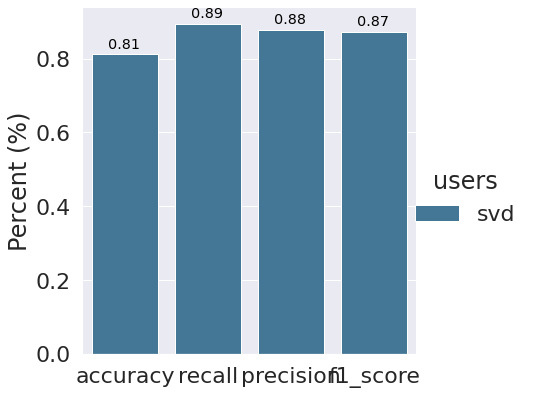

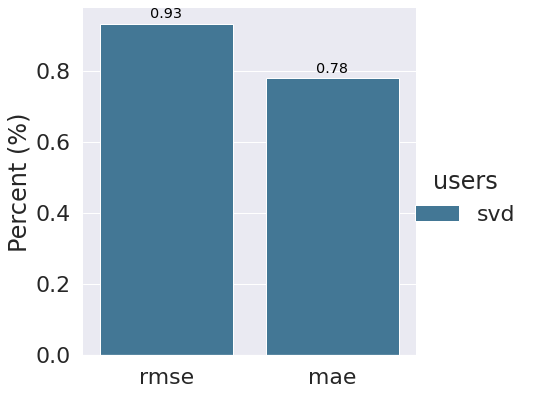

In [ ]:


df = pd.DataFrame(columns=['model','metric','score'])
df2 = pd.DataFrame(columns=['model','metric','score'])
for u in [3]:
  #model = cf_svd(input_user = u,dataset = data,columns = columns)
  grade_df = model_svd.evaluate_system(all_train,all_test)
  a,b = eval.average_arpf_rm(data=grade_df,cols=columns,threshold=3,model='svd')
  df = df.append(a)
  df2 = df2.append(b)

eval.visualize_bars(df = df,axe_x='metric',axe_y='score',hue='model',title='users',x_dist=0.2,hei_=6,asp_=6/6)

eval.visualize_bars(df = df2,axe_x='metric',axe_y='score',hue='model',title='users',x_dist=0.3,hei_=6,asp_=6/6)

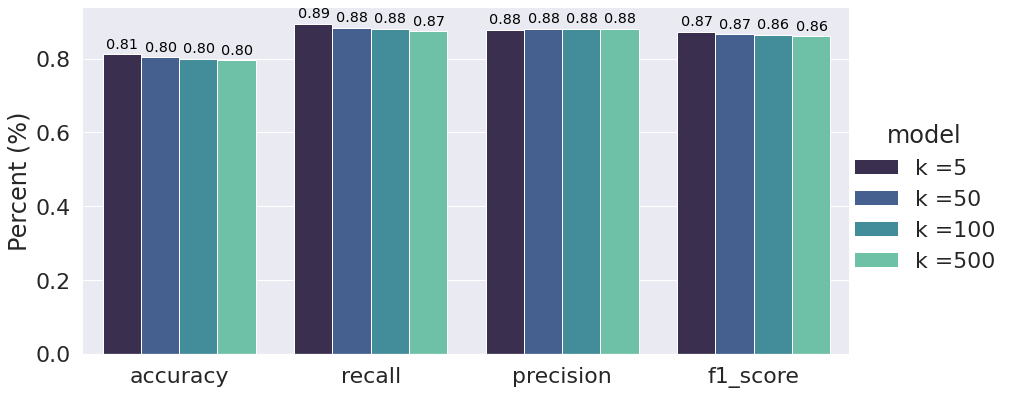

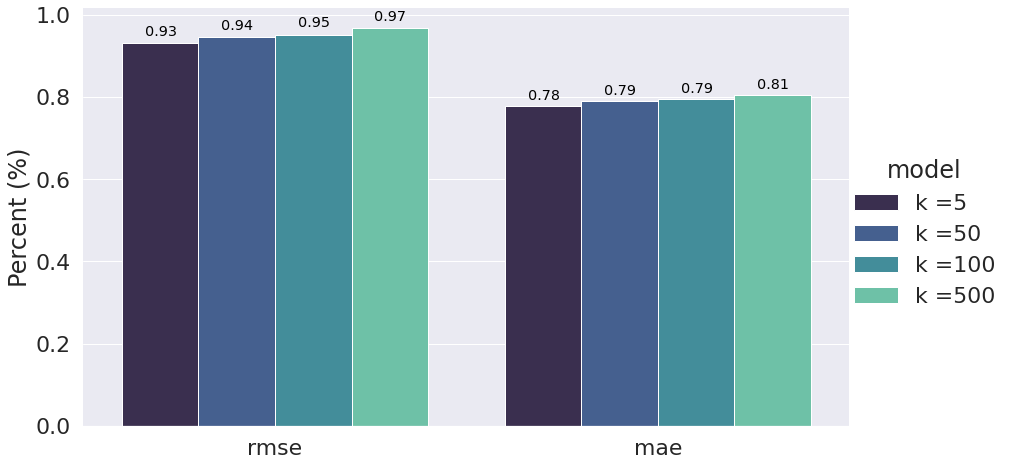

In [ ]:
eval = evaluator()
df = pd.DataFrame(columns=['model','metric','score'])
df2 = pd.DataFrame(columns=['model','metric','score'])

for i in range(len(model_svd.all_ev)):
  grade_df = model_svd.all_ev[i]
  a,b = eval.average_arpf_rm(data=grade_df,cols=columns,threshold=3,model='k ='+str(model_svd.feature_num[i]))
  df = df.append(a)
  df2 = df2.append(b)

eval.visualize_bars(df = df,axe_x='metric',axe_y='score',hue='model',title='model',x_dist=0.02,hei_=6,asp_=12/6)

eval.visualize_bars(df = df2,axe_x='metric',axe_y='score',hue='model',title='model',x_dist=0.06,hei_=7,asp_=12/7)

# **`svd_cov_nov.py`**





In [ ]:
eval = evaluator()
model_svd = cf_svd(eval,0,dataset,columns)

In [ ]:
model

In [ ]:
cat_ = features_df
#translator_ = pd.read_pickle('/content/drive/My Drive/cat_translator.pkl')
dffff = model_svd.coverage(6.3)
df2 = model_svd.novelty(6.3,cat_)
 
evaluator().visualize_pie(dffff,df2)

# **`cf_deep_model.py`**

In [ ]:
from keras.models import Model
from keras.layers import Input, Reshape, Dot
from keras.layers.embeddings import Embedding
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.layers import Concatenate, Dense, Dropout
from keras.layers import Add, Activation, Lambda
from keras.layers import LeakyReLU

class cf_deep_model():

  def EmbeddingLayer(self,x,total_rows,total_cols):
    x = Embedding(total_rows, total_cols, embeddings_initializer='he_normal',
                      embeddings_regularizer=l2(1e-6))(x)
    x = Reshape((total_cols,))(x)
    return x

  def __init__(self,t_users,t_items,factors,min_rating,max_rating):
    
    self.t_users = t_users
    self.t_items = t_items
    self.factors = factors

    user = Input(shape=(1,))
    u = self.EmbeddingLayer(user,t_users, factors)
    
    item = Input(shape=(1,))
    i = self.EmbeddingLayer(item,t_items, factors)
    
    x = Concatenate()([u, i])
    #x = Dropout(0.1)(x)
    
    x = Dense(4096, kernel_initializer='glorot_normal')(x)
    x = Activation('relu')(x)
    x = Dropout(0.55)(x)

    x = Dense(2048, kernel_initializer='glorot_normal')(x)
    x = Activation('relu')(x)
    x = Dropout(0.45)(x)

    x = Dense(1024, kernel_initializer='glorot_normal')(x)
    x = Activation('relu')(x)
    x = Dropout(0.3)(x)

    x = Dense(512, kernel_initializer='glorot_normal')(x)
    x = Activation('relu')(x)
    x = Dropout(0.3)(x)

    x = Dense(256, kernel_initializer='glorot_normal')(x)
    x = Activation('relu')(x)
    x = Dropout(0.3)(x)

    x = Dense(128, kernel_initializer='glorot_normal')(x)
    x = Activation('relu')(x)
    x = Dropout(0.3)(x)

    x = Dense(64, kernel_initializer='glorot_normal')(x)
    x = Activation('relu')(x)
    x = Dropout(0.3)(x)

    x = Dense(32, kernel_initializer='glorot_normal')(x)
    x = Activation('relu')(x)
    x = Dropout(0.3)(x)
    
    x = Dense(1, kernel_initializer='he_normal')(x)
    x = Activation('linear')(x)
    #x = LeakyReLU(alpha=0.1)(x)
    x = Lambda(lambda x: x * (max_rating - min_rating) + min_rating)(x)    
    self.model = Model(inputs=[user, item], outputs=x)
    #opt = Adam(lr=0.01)
 
    #self.model.compile(loss='mean_absolute_error', optimizer=opt)


# **`cf_deep.py`**

In [ ]:
import keras
import tensorflow as tf 
from keras.callbacks import ModelCheckpoint

class cf_deep():

  def __init__(self,preprocess_pack,handler,cols,user_input):
    self.evdf = -1
    self.user_input = user_input
    self.handler = handler
    self.cols = cols
    df , t_users, t_items , minmax , enc , enc2 = preprocess_pack
    self.df = df
    self.t_users = t_users
    self.t_items = t_items
    self.min_rating , self.max_rating = minmax
    self.enc = enc
    self.enc2 = enc2
    self.model = cf_deep_model(t_users,t_items,70,self.min_rating,self.max_rating).model
    self.recdf = -1
  def make_recommendation(self):
    # make local variables
    if type(self.recdf) == type(pd.DataFrame()):
      return self.recdf
    input_user = self.user_input
    data =   self.df
    cols =   self.cols

    if type(self.recdf)  == type(pd.DataFrame()):
      return self.recdf
   
    train,test = self.handler.rec_split(self.df)
   
    X_train,y_train,X_test,y_test = self.convertInput(train,test)

    X_train[0] = X_train[0].astype('float64')
    X_train[1] = X_train[1].astype('float64')
    X_test[0] = X_test[0].astype('float64')
    X_test[1] = X_test[1].astype('float64')
    y_train = np.array(y_train).astype('float64')
    y_test = np.array(y_test).astype('float64')
    
    self.train(X_train,y_train,X_test,y_test)
    
    self.load_best_model()

    train_items = np.unique(X_train[1])
    print(len(train_items))

    # get unrated ratings per user
    all_users = data[cols[0]].unique()
    all_items = set(data[cols[1]].unique())

    print(len(all_items))
    # dataframe for recommendation
    df = pd.DataFrame(columns=[columns[0],columns[1],'y_rec'])
    for i in all_users:
      u_data = data.loc[data[cols[0]] == i]
      rated = set(u_data[cols[1]].unique())
      unrated = list(all_items - rated)
      if len(unrated) > 0 :
        a = [i for k in range(len(unrated))]
        X_pred = [np.array(a).astype('float64'), np.array(unrated).astype('float64')]
        y_rec = self.model.predict(X_pred)
        p_data = pd.DataFrame(columns=[columns[0],columns[1],'y_rec'])
        p_data[columns[0]] = self.enc2.inverse_transform(a)
        p_data[columns[1]] = self.enc.inverse_transform(unrated)
        p_data['y_rec'] = y_rec
        df = df.append(p_data)


    df = df.reset_index().drop(columns='index')
 
    self.recdf = df
    return df

  def convertInput(self,train,test):
    TRAIN = train.values
    TEST = test.values
    X_train = [TRAIN[:, 0], TRAIN[:, 1]]
    y_train = TRAIN[:, 2]
    X_test = [TEST[:, 0], TEST[:, 1]]
    y_test = TEST[:, 2]
    return X_train,y_train,X_test,y_test

  def recommend(self,itemsTopredict):
    
    train,test = self.handler.rec_split(self.df)
   
    X_train,y_train,X_test,y_test = self.convertInput(train,test)
    
    self.train(X_train,y_train,X_test,y_test)
    
    self.load_best_model()
    
    canTransform = self.enc.classes_
    itemstp = []
    for i in range(len(itemsTopredict)):
      if itemsTopredict[i] in canTransform:
        itemstp.append(itemsTopredict[i])
    predItems = self.enc.transform(itemstp)
    a = [self.user_input for i in range(len(predItems))]
    X_pred = [np.array(a), np.array(predItems)]
    y_pred = np.array(self.model.predict(X_pred))
    df = pd.DataFrame(columns=[self.cols[1],'dl_pred'])
    df[self.cols[1]] = self.enc.inverse_transform(predItems)
    df['dl_pred'] = y_pred
    c = df[self.cols[1]].tolist()
    for i in range(len(itemsTopredict)):
      if itemsTopredict[i] not in c:
        itemId = itemsTopredict[i]
        df = df.append(pd.DataFrame(data=[[itemId,np.nan]],columns=[self.cols[1],'dl_pred']))

    return df

  def evaluate_system(self,all_train,all_test):
    if type( self.evdf) == type(pd.DataFrame()):
      return  self.evdf
    # make local 
    cols = self.cols
    df = self.df

    train = all_train.copy()
    test = all_test.copy()
    train[cols[0]] = self.enc2.transform(train[cols[0]].tolist())
    test[cols[0]] = self.enc2.transform(test[cols[0]].tolist())

    train[cols[1]] =  self.enc.transform(train[cols[1]].tolist())
    test[cols[1]] = self.enc.transform(test[cols[1]].tolist())

    # convert input for neural network
    X_train,y_train,X_test,y_test = self.convertInput(train,test)

    # fix datatype tensor error
    X_train[0] = X_train[0].astype('float64')
    X_train[1] = X_train[1].astype('float64')
    X_test[0] = X_test[0].astype('float64')
    X_test[1] = X_test[1].astype('float64')
    y_train = np.array(y_train).astype('float64')
    y_test = np.array(y_test).astype('float64')

    # train and load
    self.train(X_train,y_train,X_test,y_test)
    self.load_best_model()

    # create prediction dataframe
    y_pred = np.array(self.model.predict(X_test))
    df = pd.DataFrame(columns=[cols[0],cols[1],'y_true','y_pred'])
    df[cols[0]] =  self.enc2.inverse_transform(test[cols[0]].tolist())
    df[cols[1]] =  self.enc.inverse_transform(test[cols[1]].tolist())
    df['y_true'] = y_test
    df['y_pred'] = y_pred

    # reset index  
    df = df.reset_index().drop(columns='index')
    self.evdf = df
    return df
  def split_and_predict(self):
    # split data to train and test set
    train,test = self.handler.split(self.df,self.user_input,0.2)
    X_train,y_train,X_test,y_test = self.convertInput(train,test)
    
    self.train(X_train,y_train,X_test,y_test)
    self.load_best_model()
    y_pred = np.array(self.model.predict(X_test))
    df = pd.DataFrame(columns=[self.cols[1],'y_true','y_pred'])
    df[self.cols[1]] = test[self.cols[1]].tolist()
    df['y_true'] = y_test
    df['y_pred'] = y_pred

    return df
    
  def train(self,X_train,y_train,X_test,y_test):
    filepath ="/content/drive/My Drive/models/weights_dl.hdf5"
    # Keep only a single checkpoint, the best over test accuracy.
    checkpoint = ModelCheckpoint(filepath,
                              monitor='val_loss',
                              verbose=1,
                              save_best_only=True,
                              mode='min')   

    self.model.compile(optimizer= 'adam', loss=tf.keras.losses.MeanSquaredError())
    #MeanSquaredError
    train = self.model.fit(x=X_train, y=np.array(y_train),
            batch_size=512,
            epochs=25,
            verbose=1,
            validation_data=(X_test, np.array(y_test)),
            shuffle=True,
            callbacks=[checkpoint])
    # convert the history.history dict to a pandas DataFrame:     
    hist_df = pd.DataFrame(train.history) 
    # save to csv: 
    hist_csv_file = '/content/drive/My Drive/models/history_dl.csv'
    with open(hist_csv_file, mode='w') as f:
        hist_df.to_csv(f) 

  def load_best_model(self):
    filepath ="/content/drive/My Drive/models/weights_dl.hdf5"
    self.model = cf_deep_model(self.t_users,self.t_items,70,self.min_rating,self.max_rating).model
    self.model.load_weights(filepath)

  def hyb_eval(self,train,test):

    itemsTopredict = test[self.cols[1]].tolist()

    #print(test[self.cols[1]])
    u_test = test.copy()
    u_test[self.cols[1]] = self.enc.transform(test[self.cols[1]].tolist() )
    #print(test[self.cols[1]])
    u_train = train.copy()
    u_train[self.cols[1]] = self.enc.transform(train[self.cols[1]].tolist() )

    X_train,y_train,X_test,y_test = self.convertInput(u_train,u_test)


    X_train[0] = X_train[0].astype('float64')
    X_train[1] = X_train[1].astype('float64')
    X_test[0] = X_test[0].astype('float64')
    X_test[1] = X_test[1].astype('float64')
    y_train = np.array(y_train).astype('float64')
    y_test = np.array(y_test).astype('float64')

    self.train(X_train,y_train,X_test,y_test)

    self.load_best_model()
    
    canTransform = self.enc.classes_
    itemstp = []
    for i in range(len(itemsTopredict)):
      if itemsTopredict[i] in canTransform:
        itemstp.append(itemsTopredict[i])
    predItems = self.enc.transform(itemstp)
    a = [self.user_input for i in range(len(predItems))]
    X_pred = [np.array(a), np.array(predItems)]
    y_pred = np.array(self.model.predict(X_pred))
    df = pd.DataFrame(columns=[self.cols[1],'dl_pred'])
    df[self.cols[1]] = self.enc.inverse_transform(predItems)
    df['dl_pred'] = y_pred
    c = df[self.cols[1]].tolist()
    for i in range(len(itemsTopredict)):
      if itemsTopredict[i] not in c:
        itemId = itemsTopredict[i]
        df = df.append(pd.DataFrame(data=[[itemId,np.nan]],columns=[self.cols[1],'dl_pred']))
    return df

  def coverage(self,threshold=5):

    if type(self.recdf)  != type(pd.DataFrame()):
      pred_ratings = self.make_recommendation()
    else:
      pred_ratings = self.recdf

    already_rated = len(self.df)
    
    high_rated = len(pred_ratings.loc[pred_ratings['y_rec']>threshold])
    
    low_rated = len(pred_ratings.loc[pred_ratings['y_rec']<=threshold])

    unrated = len(pred_ratings.loc[pred_ratings['y_rec']==np.nan])
    
    cov_df = pd.DataFrame()

    cov_df['recommended'] = [high_rated]

    cov_df['not recommended'] = [low_rated]

    cov_df['cannot recommended'] = [unrated]

    cov_df['already rated'] = [already_rated]
    
    return cov_df
    
 
 
  def novelty(self,cat_,threshold=5,translator_=False):

    if type(self.recdf) != type(pd.DataFrame()):
      pred_ratings = self.make_recommendation()
    else:
      pred_ratings = self.recdf

    pred_ratings = pred_ratings.merge(cat_,on=columns[1],how='inner')

    categories = pred_ratings['category'].unique()

    c_ratings = []
    for i in range(len(categories)):
      ratings = []
      fr = pred_ratings.loc[pred_ratings['category'] == categories[i]]
      ratings.append(round(len(fr.loc[fr['y_rec'] >=threshold])  / len(fr.loc[fr['y_rec'] >=0]),2) )
      ratings.append(round(len(fr.loc[fr['y_rec'] <threshold])  / len(fr.loc[fr['y_rec'] >=0]) ,2))
      c_ratings.append(ratings)

    df = pd.DataFrame(data=c_ratings , columns=['προτείνεται','δεν προτείνεται'])
    if type(translator_) == bool:
      return df

    categories_gr = []
 
    for i in range(len(categories)):
      categories_gr.append(translator_.loc[translator_['category'] == categories[i]].index.tolist()[0])
    df['κατηγορίες'] = categories_gr

    df = df.set_index(keys='κατηγορίες')

    return df
    #4.5

# **`cf_deep_main.py`**

In [ ]:
handler = data_handler(path,columns)

preprocess_pack = handler.deep_preprocessing(data)

eval = evaluator()
dl = cf_deep(preprocess_pack,handler,columns,0)

Epoch 1/25
177/177 [==============================] - 4s 19ms/step - loss: 2.9908 - val_loss: 0.9092

Epoch 00001: val_loss improved from inf to 0.90920, saving model to /content/drive/My Drive/models/weights_dl.hdf5
Epoch 2/25
177/177 [==============================] - 3s 18ms/step - loss: 1.0319 - val_loss: 0.8763

Epoch 00002: val_loss improved from 0.90920 to 0.87628, saving model to /content/drive/My Drive/models/weights_dl.hdf5
Epoch 3/25
177/177 [==============================] - 3s 18ms/step - loss: 0.8859 - val_loss: 0.8327

Epoch 00003: val_loss improved from 0.87628 to 0.83272, saving model to /content/drive/My Drive/models/weights_dl.hdf5
Epoch 4/25
177/177 [==============================] - 3s 18ms/step - loss: 0.7996 - val_loss: 0.7792

Epoch 00004: val_loss improved from 0.83272 to 0.77924, saving model to /content/drive/My Drive/models/weights_dl.hdf5
Epoch 5/25
177/177 [==============================] - 3s 18ms/step - loss: 0.7235 - val_loss: 0.8088

Epoch 00005: val_l

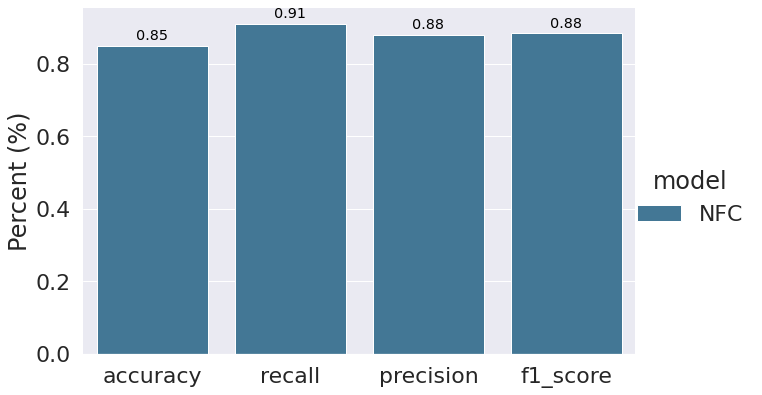

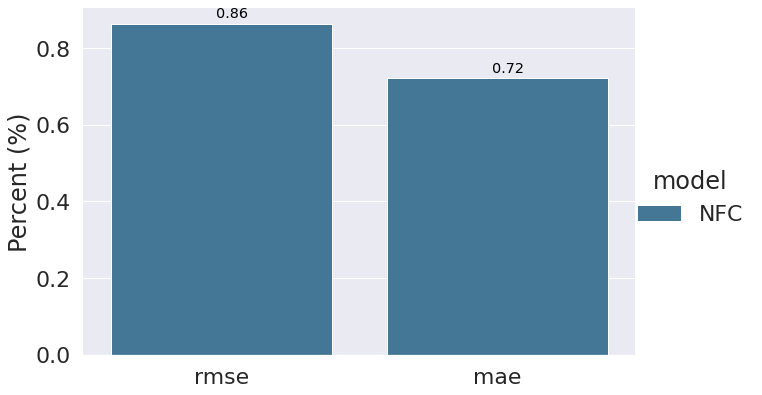

In [ ]:
handler = data_handler(path,columns)

preprocess_pack = handler.deep_preprocessing(data)

eval = evaluator()

df = pd.DataFrame(columns=['model','metric','score'])
df2 = pd.DataFrame(columns=['model','metric','score'])

for u in range(1):
  #dl = cf_deep(preprocess_pack,handler,columns,0)
  grade_df = dl.evaluate_system(all_train,all_test)
  a,b = eval.average_arpf_rm(data=grade_df,cols=columns,threshold=2.8,model='ΝFC')
  df = df.append(a)
  df2 = df2.append(b)
eval.visualize_bars(df = df,axe_x='metric',axe_y='score',hue='model',title='model',x_dist=0.28,hei_=6,asp_=9/6)
eval.visualize_bars(df = df2,axe_x='metric',axe_y='score',hue='model',title='model',x_dist=0.38,hei_=6,asp_=9/6)

# **`cf_deep_cov_nov.py`**

In [ ]:
handler = data_handler(path,columns)

preprocess_pack = handler.deep_preprocessing(dataset)

eval = evaluator()
dl = cf_deep(preprocess_pack,handler,columns,0)

In [ ]:
cat_ = features_df
translator = pd.DataFrame(columns=['category'])
translator['category'] = features_df['category'].unique().tolist()
translator['gr'] = features_df['category'].unique().tolist()
translator = translator.set_index(keys='gr')
dffff = dl.coverage(threshold=3.5)
df2 = dl.novelty(cat_,3.5,translator)

evaluator().visualize_pie(dffff,df2)

Epoch 1/25
195/195 [==============================] - 4s 18ms/step - loss: 0.6394 - val_loss: 0.6752

Epoch 00001: val_loss improved from inf to 0.67517, saving model to /content/drive/My Drive/models/weights_dl.hdf5
Epoch 2/25
195/195 [==============================] - 3s 17ms/step - loss: 0.5464 - val_loss: 0.6761

Epoch 00002: val_loss did not improve from 0.67517
Epoch 3/25
195/195 [==============================] - 3s 17ms/step - loss: 0.4715 - val_loss: 0.6963

Epoch 00003: val_loss did not improve from 0.67517
Epoch 4/25
195/195 [==============================] - 3s 17ms/step - loss: 0.4248 - val_loss: 0.6921

Epoch 00004: val_loss did not improve from 0.67517
Epoch 5/25
195/195 [==============================] - 3s 18ms/step - loss: 0.3783 - val_loss: 0.7186

Epoch 00005: val_loss did not improve from 0.67517
Epoch 6/25
195/195 [==============================] - 3s 17ms/step - loss: 0.3481 - val_loss: 0.7255

Epoch 00006: val_loss did not improve from 0.67517
Epoch 7/25
195/195

KeyboardInterrupt: ignored

In [ ]:
df

model     metric     score
0   ΝFC   accuracy  0.849332
1   ΝFC     recall  0.908534
2   ΝFC  precision  0.879481
3   ΝFC   f1_score  0.883344

In [ ]:
features_df['category'].unique().tolist()

['Δράση',
 'Παιδικά',
 'Κωμωδία',
 'Φαντασία',
 'Ρομαντική',
 'Δράμα',
 'Μυστηριο',
 'Θρίλερ',
 'Πολεμική',
 'Μιούζικαλ',
 'Δοκιμαντέρ']

In [ ]:
dffff

recommended  not recommended  cannot recommended  already rated
0           17           117378                   0          53505

# a

In [ ]:
handler = data_handler(path,columns)

preprocess_pack = handler.deep_preprocessing(data)

eval = evaluator()

dl = cf_deep(preprocess_pack,handler,columns,u)
dl.hyb_eval(all_train,all_test)

Epoch 1/10
625/629 [============================>.] - ETA: 0s - loss: 0.8121
Epoch 00001: val_loss improved from inf to 0.73853, saving model to /content/drive/My Drive/models/weights_dl.hdf5
629/629 [==============================] - 7s 10ms/step - loss: 0.8117 - val_loss: 0.7385
Epoch 2/10
627/629 [============================>.] - ETA: 0s - loss: 0.7114
Epoch 00002: val_loss improved from 0.73853 to 0.70483, saving model to /content/drive/My Drive/models/weights_dl.hdf5
629/629 [==============================] - 6s 9ms/step - loss: 0.7114 - val_loss: 0.7048
Epoch 3/10
623/629 [============================>.] - ETA: 0s - loss: 0.6930
Epoch 00003: val_loss did not improve from 0.70483
629/629 [==============================] - 5s 8ms/step - loss: 0.6931 - val_loss: 0.7375
Epoch 4/10
628/629 [============================>.] - ETA: 0s - loss: 0.6954
Epoch 00004: val_loss did not improve from 0.70483
629/629 [==============================] - 5s 9ms/step - loss: 0.6954 - val_loss: 0.7809

KeyboardInterrupt: ignored

# content based preprocessing for cf and nn

In [ ]:
genres = pd.read_csv('/content/drive/My Drive/ml-latest-small/movies.csv')

w_data = data.copy()

w_data = w_data.merge(genres,on='movieId')

a = genres['genres']

sett = a.str.get_dummies()

aa = pd.concat(
    [genres.drop(
        ['genres'],
        axis=1
    ),
     sett],
    axis=1
)

In [ ]:
aa

movieId                                      title  ...  War  Western
0           1                           Toy Story (1995)  ...    0        0
1           2                             Jumanji (1995)  ...    0        0
2           3                    Grumpier Old Men (1995)  ...    0        0
3           4                   Waiting to Exhale (1995)  ...    0        0
4           5         Father of the Bride Part II (1995)  ...    0        0
...       ...                                        ...  ...  ...      ...
9737   193581  Black Butler: Book of the Atlantic (2017)  ...    0        0
9738   193583               No Game No Life: Zero (2017)  ...    0        0
9739   193585                               Flint (2017)  ...    0        0
9740   193587        Bungo Stray Dogs: Dead Apple (2018)  ...    0        0
9741   193609        Andrew Dice Clay: Dice Rules (1991)  ...    0        0

[9742 rows x 22 columns]

In [ ]:
features = aa.copy()
features = features.set_index(keys='movieId')
features = features.drop(columns=['title','(no genres listed)'])
dataset = data
#nn = cb_nn(0,features)

In [ ]:
features

Action  Adventure  Animation  Children  ...  Sci-Fi  Thriller  War  Western
movieId                                          ...                                
1             0          1          1         1  ...       0         0    0        0
2             0          1          0         1  ...       0         0    0        0
3             0          0          0         0  ...       0         0    0        0
4             0          0          0         0  ...       0         0    0        0
5             0          0          0         0  ...       0         0    0        0
...         ...        ...        ...       ...  ...     ...       ...  ...      ...
193581        1          0          1         0  ...       0         0    0        0
193583        0          0          1         0  ...       0         0    0        0
193585        0          0          0         0  ...       0         0    0        0
193587        1          0          1         0  ...       0         0    0        0
193609        0          0          0         0  ...       0         0    0        0

[9742 rows x 19 columns]

In [ ]:
FEATURES = pd.DataFrame()

action = features['Action'].tolist()
adventure = features['Adventure'].tolist()

ACTION = [] # 1

for i in range(len(features)):
  ACTION.append(int(action[i] or adventure[i]))

CHILDREN = [] # 2

animation = features['Animation'].tolist() 
children = features['Children'].tolist() 

for i in range(len(features)):
  CHILDREN.append(int(animation[i] or children[i]))

COMEDY = features['Comedy'].tolist() # 3

crime = features['Crime'].tolist()
mystery = features['Mystery'].tolist()

MYSTERY = [] # 4

for i in range(len(features)):
  MYSTERY.append(int(crime[i] or mystery[i]))

DOC = features['Documentary'].tolist() #5

DRAMA = features['Drama'].tolist() #6

SCI_FI = [] # 7

fantacy = features['Fantasy'].tolist() 
sci_fi = features['Sci-Fi'].tolist() 

for i in range(len(features)):
  SCI_FI.append(int(fantacy[i] or sci_fi[i]))

HORROR = [] # 8

horror = features['Horror'].tolist() 
thriler = features['Thriller'].tolist() 

for i in range(len(features)):
  HORROR.append(int(horror[i] or thriler[i]))

MUSICAL = features['Musical'].tolist()  # 9

ROMANCE =  features['Romance'].tolist()  # 10

WAR =  [] # 11
war = features['War'].tolist()  
western =  features['Western'].tolist()  

for i in range(len(features)):
  WAR.append(int(war[i] or western[i]))


In [ ]:
def remove_column_name(value):
    return value[value.rfind('_')+1:]

def check_categorical_column(columns):
    dict_column_name = {}
    for column in columns:
        name = column[:column.rfind('_')]
        dict_column_name.setdefault(name,[]).append(column)
    return dict_column_name

def reverse_dummies(df):
    df_temp = df.copy()
    dict_column_name = check_categorical_column(df_temp)
    for key, value in dict_column_name.items():
        if len(value) > 1:
            dummies = df_temp[value]
            df_temp[key] = pd.Series(dummies.columns[np.where(dummies != 0)[1]])
            df_temp[key] = df_temp[key].apply(remove_column_name)
            df_temp.drop(value, axis=1, inplace=True)
    return df_temp

reverse_dummies(FEATURES)

Empty DataFrame
Columns: []
Index: []

In [ ]:
FEATURES['Δράση'] = ACTION
FEATURES['Παιδικά'] = CHILDREN
FEATURES['Κωμωδία'] = COMEDY
FEATURES['Μυστηριο'] = MYSTERY
FEATURES['Δοκιμαντέρ'] = DOC
FEATURES['Δράμα'] = DRAMA
FEATURES['Φαντασία'] = SCI_FI
FEATURES['Θρίλερ'] = HORROR
FEATURES['Μιούζικαλ'] = MUSICAL
FEATURES['Ρομαντική'] = ROMANCE
FEATURES['Πολεμική'] = WAR
len(np.array(FEATURES.idxmax(axis=1)))
#pd.Series(FEATURES.columns[np.where(dummies!=0)[1]])

9742

In [ ]:
features_df = pd.DataFrame(columns=['movieId','category'])
for i in range(len(features)):
  row = FEATURES.iloc[i]
  for j in FEATURES.columns:
    if row[j] == 1:
      features_df = features_df.append(pd.DataFrame(columns=['movieId','category'],data=[[features.index.tolist()[i],j]]))




In [ ]:
features_df = features_df.reset_index().drop(columns=['index'])

In [ ]:

eval = evaluator()

df = pd.DataFrame(columns=['user','metric','score'])
df2 = pd.DataFrame(columns=['user','metric','score'])

for u in range(1):
  #model = cb_nn(0,features)
  grade_df = nn.evaluate_system(all_train,all_test)
  a,b = eval.average_arpf_rm(data=grade_df,cols=columns,threshold=4.5,model='cb_nn')
  df = df.append(a)
  df2 = df2.append(b)
eval.visualize_bars(df = df,axe_x='metric',axe_y='score',hue='model',title='model')
eval.visualize_bars(df = df2,axe_x='metric',axe_y='score',hue='model',title='model')


Streaming output truncated to the last 5000 lines.
2/2 [==============================] - 0s 212ms/step - loss: 0.9956 - mae: 0.9956 - val_loss: 0.8665 - val_mae: 0.8665
Epoch 1/10
1/1 [==============================] - 1s 553ms/step - loss: 3.6522 - mae: 3.6522 - val_loss: 1.0494 - val_mae: 1.0494
Epoch 2/10
1/1 [==============================] - 0s 57ms/step - loss: 1.1512 - mae: 1.1512 - val_loss: 2.3746 - val_mae: 2.3746
Epoch 3/10
1/1 [==============================] - 0s 57ms/step - loss: 3.1394 - mae: 3.1394 - val_loss: 1.0186 - val_mae: 1.0186
Epoch 4/10
1/1 [==============================] - 0s 57ms/step - loss: 1.6915 - mae: 1.6915 - val_loss: 2.0761 - val_mae: 2.0761
Epoch 5/10
1/1 [==============================] - 0s 54ms/step - loss: 1.7877 - mae: 1.7877 - val_loss: 2.3815 - val_mae: 2.3815
Epoch 6/10
1/1 [==============================] - 0s 59ms/step - loss: 2.0804 - mae: 2.0804 - val_loss: 1.3077 - val_mae: 1.3077
Epoch 7/10
1/1 [==============================] - 0s 64

AttributeError: ignored

# **`plot`** 

In [ ]:
df1 = pd.read_pickle('/content/drive/My Drive/df_lens/rm_dl.pkl')
df2 = pd.read_pickle('/content/drive/My Drive/df_lens/rm_svd.pkl')
df3 = pd.read_pickle('/content/drive/My Drive/df_lens/rm_hyb_mean.pkl')
df4 = pd.read_pickle('/content/drive/My Drive/df_lens/rm_hyb_reg.pkl')

df1 = df1.append(df2)
df1 = df1.append(df3)
df1 = df1.append(df4)

In [ ]:
df1.loc[df1['metric']=='rmse']

model metric     score
0  collaborative neural network   rmse  0.906527
0                           svd   rmse  0.980409
0                   hybrid_mean   rmse  0.889573
0                    hybrid_reg   rmse  0.879517

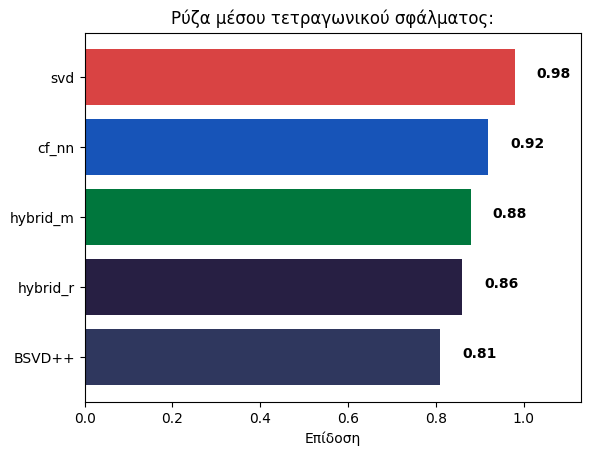

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Fixing random state for reproducibility
np.random.seed(19680801)


plt.rcdefaults()
fig, ax = plt.subplots()

# Example data
people = ('svd', 'cf_nn', 'hybrid_m', 'hybrid_r','BSVD++')
y_pos = np.arange(len(people))
performance = [0.98,0.92,0.88,0.86,0.81]

ax.barh(y_pos, performance, align='center',color=['#d94343','#1754b8','#00773d','#271f43','#2f375e'])
ax.set_yticks(y_pos)
ax.set_yticklabels(people)
ax.set_xlim(0,1.13)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Επίδοση')
ax.set_title('Ρύζα μέσου τετραγωνικού σφάλματος:')
for i, v in enumerate(performance):
    ax.text(v+0.05 , i  , str(v), fontweight='bold')
plt.show()

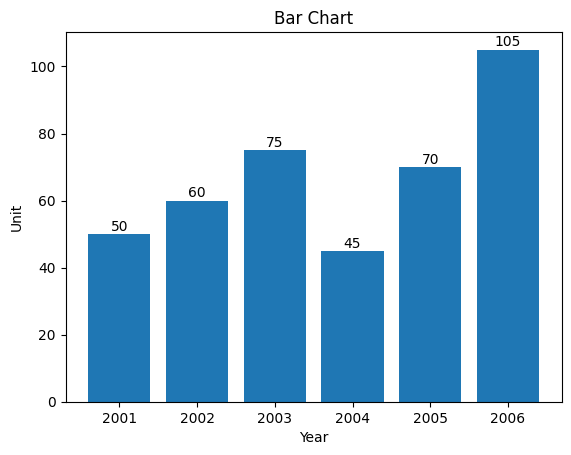

In [ ]:
import matplotlib.pyplot as plt
 
year = [2001, 2002, 2003, 2004, 2005, 2006]
unit = [50, 60, 75, 45, 70, 105]
 
# Plot the bar graph
plot = plt.bar(year, unit)

# Add the data value on head of the bar
for value in plot:
    height = value.get_height()
    plt.text(value.get_x() + value.get_width()/2.,
             1.002*height,'%d' % int(height), ha='center', va='bottom')
 
# Add labels and title
plt.title("Bar Chart")
plt.xlabel("Year")
plt.ylabel("Unit")
 
# Display the graph on the screen
plt.show()

# **`hybrid_v2.py`**

In [ ]:
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn import linear_model
import pandas as pd
import numpy as np

class hybrid_v2():

  def __init__(self,dataset,cols,models,all_train,all_test):
    self.models = models
    self.dataset = dataset
    self.cols = cols
    self.linear_reg = -1
    self.poly_reg = - 1
    self.all_train = all_train
    self.all_test = all_test
    self.recdf = -1
    

  def make_recommendation(self):
    if type(self.recdf) == type(pd.DataFrame()):
      return self.recdf
    # make variables local
    models = self.models
    dataset = self.dataset
    cols = self.cols

    if type(self.linear_reg) == type(Pipeline([('polynomial',PolynomialFeatures(degree=1)),('modal',LinearRegression())])):
      linear_reg = self.linear_reg
      poly_reg = self.poly_reg
    else:
      self.evaluate_system()
      linear_reg = self.linear_reg
      poly_reg = self.poly_reg
    
    df = models[0].make_recommendation()

    df = df.rename(columns={'y_rec':'pred_0'})
    for i in range(1,len(models)):
          df_ = models[i].make_recommendation()
          df_ = df_.rename(columns={'y_rec':'pred_'+str(i)})
          df = df.merge(df_,on=[columns[0],columns[1]],how='inner')
    
    X = df[df.columns[2:]].values
    
    y_rec0 = X.mean(axis=1)
    y_rec1 = self.linear_reg.predict(X)
    y_rec2 = self.poly_reg.predict(X)

    recdf = df[df.columns[:2]]
    recdf['y_rec'] = y_rec1
    #recdf['y_rec1'] = y_rec1
    #recdf['y_rec2'] = y_rec2

    self.recdf = recdf
    return recdf
    

  def evaluate_system(self):
    # make variables local
    models = self.models
    dataset = self.dataset
    cols = self.cols
    all_train = self.all_train
    all_test = self.all_test

    df = models[0].evaluate_system(all_train,all_test)
    df = df.rename(columns={'y_pred':'pred_0'})
    for i in range(1,len(models)):
      df_ = models[i].evaluate_system(all_train,all_test)
      df_ = df_.rename(columns={'y_pred':'pred_'+str(i)})
      df = df.merge(df_,on=[columns[0],columns[1],'y_true'],how='inner')
    
    self.stat = df
    
    X = pd.DataFrame()
    for i in range(len(models)):
      X['pred_'+str(i)] = df['pred_'+str(i)]
     
    y = df['y_true']

    train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.7, random_state=42)

    average_df = pd.DataFrame()
    average_df[columns[0]] = df[columns[0]]
    average_df[columns[1]] = df[columns[1]]
    average_df['y_pred'] = X.values.mean(axis=1)
    average_df['y_true'] = df['y_true'].tolist()

    # REGRESSION DEGREE = 1 
    lr_df = pd.DataFrame()
    lr_df[columns[0]] = df[columns[0]]
    lr_df[columns[1]] = df[columns[1]]
    input_=[('polynomial',PolynomialFeatures(degree=1)),('modal',LinearRegression())]
    pipe=Pipeline(input_)
    pipe.fit(train_X.values,train_y)
    y_pred= pipe.predict(X)
    lr_df['y_pred'] = y_pred
    lr_df['y_true'] = df['y_true'].tolist()
    self.linear_reg = pipe

    # REGRESSION DEGREE = 2 
    pr_df = pd.DataFrame()
    pr_df[columns[0]] = df[columns[0]]
    pr_df[columns[1]] = df[columns[1]]
    input_=[('polynomial',PolynomialFeatures(degree=2)),('modal',LinearRegression())]
    pipe=Pipeline(input_)
    pipe.fit(train_X.values,train_y)
    y_pred= pipe.predict(X)
    pr_df['y_pred'] = y_pred
    pr_df['y_true'] = df['y_true'].tolist()
    self.poly_reg = pipe



    return average_df,lr_df


  def coverage(self):
    if type(self.recdf)  != type(pd.DataFrame()):
      pred_ratings = self.make_recommendation()
    else:
      pred_ratings = self.recdf

    already_rated = len(dataset)
    
    high_rated = len(pred_ratings.loc[pred_ratings['y_rec']>6])
    
    low_rated = len(pred_ratings.loc[pred_ratings['y_rec']<=6])

    unrated = len(pred_ratings.loc[pred_ratings['y_rec']==np.nan])
    
    cov_df = pd.DataFrame()

    cov_df['recommended'] = [high_rated]

    cov_df['not recommended'] = [low_rated]

    cov_df['cannot recommended'] = [unrated]

    cov_df['already rated'] = [already_rated]
    
    return cov_df

  def novelty(self,cat_,translator_=False):

    if type(self.recdf) != type(pd.DataFrame()):
      pred_ratings = self.make_recommendation()
    else:
      pred_ratings = self.recdf

    pred_ratings = pred_ratings.merge(cat_,on=columns[1],how='inner')

    categories = pred_ratings['category'].unique()

    c_ratings = []
    for i in range(len(categories)):
      ratings = []
      fr = pred_ratings.loc[pred_ratings['category'] == categories[i]]
      ratings.append(round(len(fr.loc[fr['y_rec'] >=6])  / len(fr.loc[fr['y_rec'] >=0]),2) )
      ratings.append(round(len(fr.loc[fr['y_rec'] <6])  / len(fr.loc[fr['y_rec'] >=0]) ,2))
      c_ratings.append(ratings)

    df = pd.DataFrame(data=c_ratings , columns=['προτείνεται','δεν προτείνεται'])
    if type(translator_) == bool:
      return df

    categories_gr = []

    for i in range(len(categories)):
      categories_gr.append(translator_.loc[translator_['category'] == categories[i]].index.tolist()[0])
    df['κατηγορίες'] = categories_gr

    df = df.set_index(keys='κατηγορίες')

    return df


# **`hybrid_system_v2.py`**

In [ ]:
handler = data_handler(path,columns)
preprocess_pack = handler.deep_preprocessing(data)
features =  pd.read_pickle('/content/drive/My Drive/clothes_attr.pkl')
models = []
#model = cf_svd(0,dataset,columns)
#models.append(model_svd)
#model = cf_deep(preprocess_pack,handler,columns,0)
models.append(dl)
models.append(rf)
models.append(nn)

In [ ]:
hyb = hybrid_v2(data,columns,models,all_train,all_test)

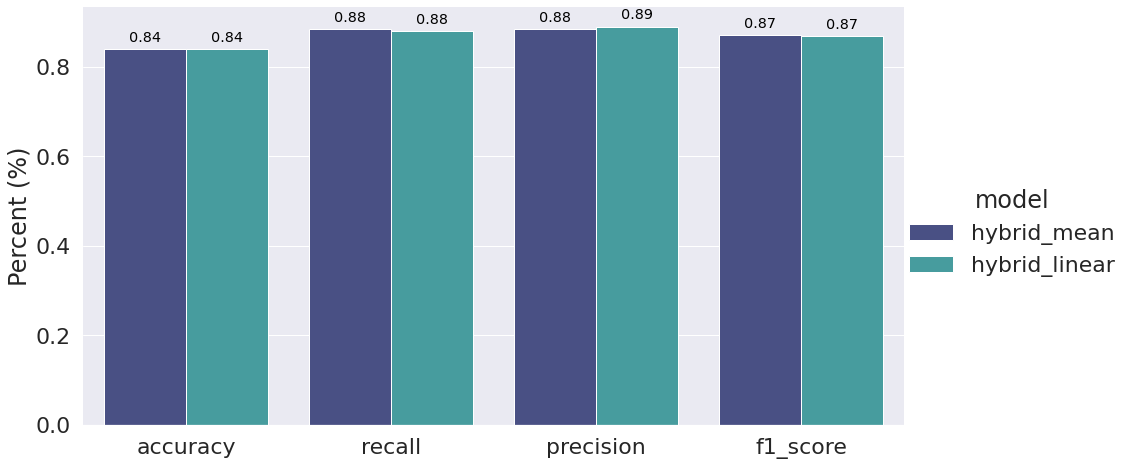

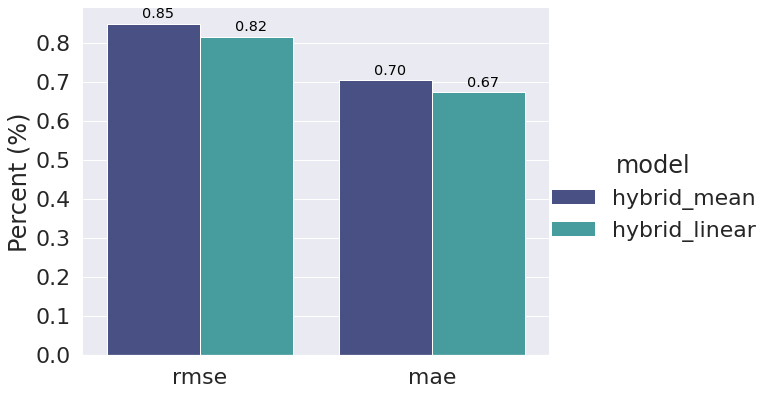

In [ ]:

df = hyb.evaluate_system()


eval = evaluator()
methods = ['hybrid_mean','hybrid_linear']
ddf = pd.DataFrame(columns=['user','metric','score'])
ddf2 = pd.DataFrame(columns=['user','metric','score'])
for i in range(len(df)):
  a,b = eval.average_arpf_rm(data=df[i],cols=columns,threshold=3,model=methods[i])
  ddf = ddf.append(a)
  ddf2 = ddf2.append(b)

eval.visualize_bars(df = ddf,axe_x='metric',axe_y='score',hue='model',title='model',x_dist=0.12,hei_=7,asp_=11/6)
eval.visualize_bars(df = ddf2,axe_x='metric',axe_y='score',hue='model',title='model',x_dist=0.15,hei_=6,asp_=8/6)

# **`hybrid_cov_nov_v2.py`**

In [ ]:
df = hyb.make_recommendation()


cat_ = features_df
translator = pd.DataFrame(columns=['category'])
translator['category'] = features_df['category'].unique().tolist()
translator['gr'] = features_df['category'].unique().tolist()
translator = translator.set_index(keys='gr')
dffff = hyb.coverage()
df2 = hyb.novelty(cat_,translator_)
 
evaluator().visualize_pie(dffff,df2)

Epoch 1/25
195/195 [==============================] - 4s 18ms/step - loss: 0.5512 - val_loss: 0.7008

Epoch 00001: val_loss improved from inf to 0.70084, saving model to /content/drive/My Drive/models/weights_dl.hdf5
Epoch 2/25
195/195 [==============================] - 3s 17ms/step - loss: 0.4775 - val_loss: 0.7162

Epoch 00002: val_loss did not improve from 0.70084
Epoch 3/25
195/195 [==============================] - 3s 17ms/step - loss: 0.4198 - val_loss: 0.7265

Epoch 00003: val_loss did not improve from 0.70084
Epoch 4/25
195/195 [==============================] - 3s 17ms/step - loss: 0.3840 - val_loss: 0.7220

Epoch 00004: val_loss did not improve from 0.70084
Epoch 5/25
195/195 [==============================] - 3s 17ms/step - loss: 0.3521 - val_loss: 0.7594

Epoch 00005: val_loss did not improve from 0.70084
Epoch 6/25
195/195 [==============================] - 3s 17ms/step - loss: 0.3299 - val_loss: 0.7640

Epoch 00006: val_loss did not improve from 0.70084
Epoch 7/25
195/195

NameError: ignored

# **`all_systems.py`**

In [ ]:
# svd

eval = evaluator()
df = pd.DataFrame(columns=['model','metric','score'])
df2 = pd.DataFrame(columns=['model','metric','score'])
for u in [3]:
  #model = cf_svd(input_user = u,dataset = data,columns = columns)
  grade_df = model_svd.evaluate_system(all_train,all_test)
  a,b = eval.average_arpf_rm(data=grade_df,cols=columns,threshold=3,model='svd')
  df = df.append(a)
  df2 = df2.append(b)

# cf deep

handler = data_handler(path,columns)

preprocess_pack = handler.deep_preprocessing(data)

eval = evaluator()
 
for u in range(1):
  #dl = cf_deep(preprocess_pack,handler,columns,0)
  grade_df = dl.evaluate_system(all_train,all_test)
  a,b = eval.average_arpf_rm(data=grade_df,cols=columns,threshold=3,model='cf_dl')
  df = df.append(a)
  df2 = df2.append(b)


for u in range(1):
  #model = cb_rf(0,features)
  grade_df = rf.evaluate_system(all_train,all_test)
  a,b = eval.average_arpf_rm(data=grade_df,cols=columns,threshold=2.5,model='rf')
  df = df.append(a)
  df2 = df2.append(b)

for u in range(1):
  #model = cb_nn(0,features)
  grade_df = nn.evaluate_system(all_train,all_test)
  a,b = eval.average_arpf_rm(data=grade_df,cols=columns,threshold=2.5,model='cb_nn')
  df = df.append(a)
  df2 = df2.append(b)


df_ = hyb.evaluate_system()


eval = evaluator()
methods = ['hybrid_mean','hybrid_linear','hybrid_polynomial ']

for i in range(1,2):
  a,b = eval.average_arpf_rm(data=df_[i],cols=columns,threshold=3,model=methods[i])
  df = df.append(a)
  df2 = df2.append(b)

In [ ]:
df = df.reset_index().drop(columns='index')
df2 = df2.reset_index().drop(columns='index')

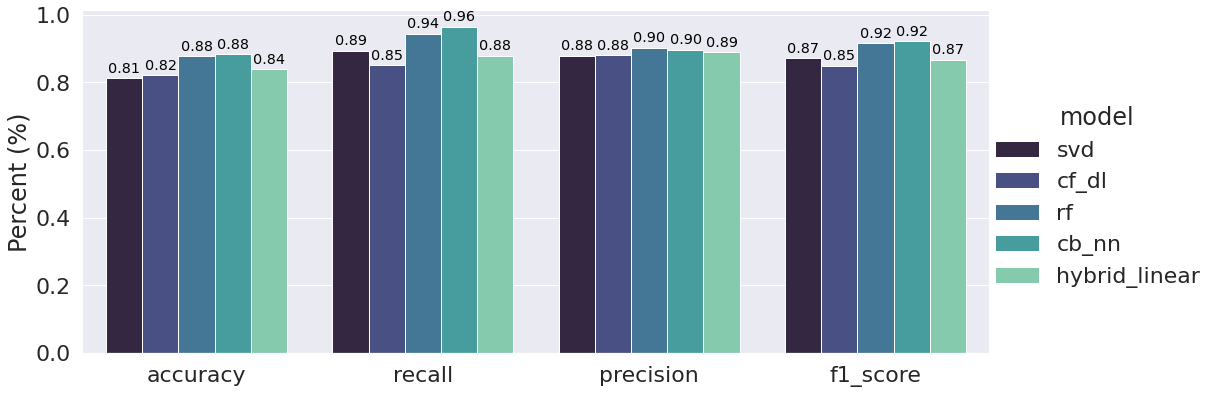

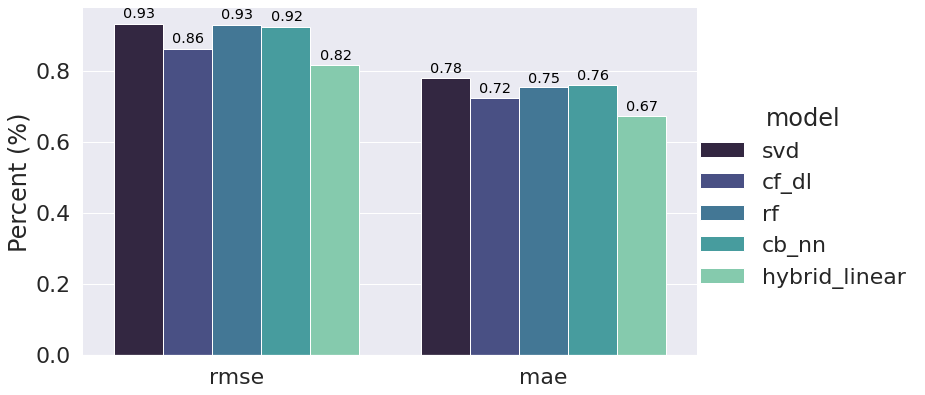

In [ ]:
eval.visualize_bars(df = df,axe_x='metric',axe_y='score',hue='model',title='model',x_dist=0.01,hei_=6,asp_=14/6)
eval.visualize_bars(df = df2,axe_x='metric',axe_y='score',hue='model',title='model',x_dist=0.03,hei_=6,asp_=10/6)

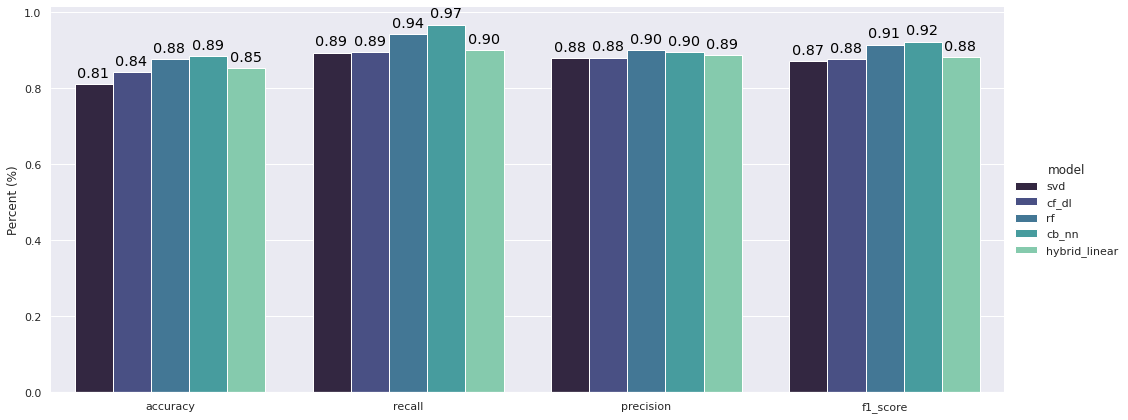

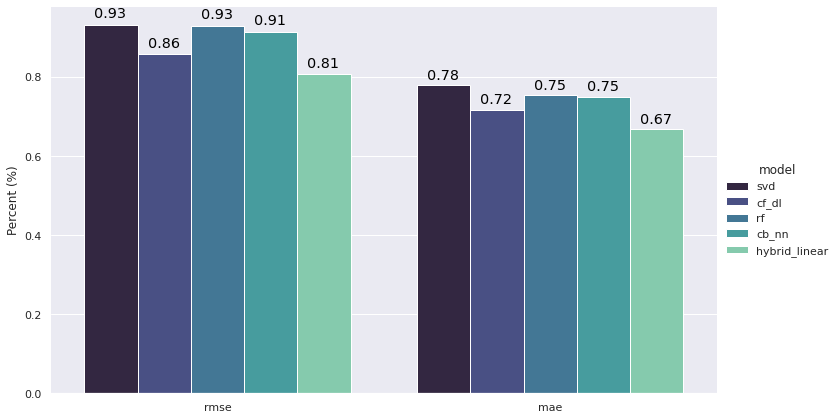

In [ ]:
eval.visualize_bars(df = df,axe_x='metric',axe_y='score',hue='model',title='model',x_dist=0.01,hei_=6,asp_=14/6)
eval.visualize_bars(df = df2,axe_x='metric',axe_y='score',hue='model',title='model',x_dist=0.03,hei_=6,asp_=10/6)

# **`cb_rf.py`**

In [ ]:
!pip install optuna

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import pandas as pd
import optuna
import sklearn

class cb_rf():
  
  def __init__(self,input_user,features):
    self.evdf = -1

    self.features = features

    self.dataset = dataset

    self.columns = columns

    self.recdf = -1

    self.input_user = input_user
    

  def make_recommendation(self):

    if type(self.recdf) == type(pd.DataFrame()):
      return self.recdf
    
    # make local variables
    dataset = self.dataset
    columns = self.columns
    features = self.features

    # get unrated ratings per user
    all_users = dataset[columns[0]].unique()
    all_items = set(dataset[columns[1]].unique())

    # dataframe for recommendation
    df = pd.DataFrame(columns=[columns[0],columns[1],'y_rec'])
    for i in all_users:
      u_data = dataset.loc[dataset[columns[0]] == i]
      train_X = features.loc[u_data[columns[1]].tolist()]
   
      train_y = u_data[columns[2]].tolist()
      self.t_x = train_X
      self.t_y = train_y

      study = optuna.create_study(direction='minimize')
      study.optimize(self.m_objective, n_trials=10)
      trial_m = study.best_trial
      regr = RandomForestRegressor(n_estimators=trial_m.params['n_estimators'],max_depth=trial_m.params['max_depth'],criterion='mse', random_state=0)
      regr.fit(train_X,train_y)
   
     
      rated = set(u_data[columns[1]].unique())
      unrated = list(all_items - rated)
      if len(unrated)>0:
        test_X = features.loc[unrated]
        y_rec = regr.predict(test_X)
        p_data = pd.DataFrame(columns=[columns[0],columns[1],'y_rec'])
        p_data[columns[0]] = [int(i) for k in range(len(unrated))]
        p_data[columns[1]] = unrated
        p_data['y_rec'] = y_rec
        df = df.append(pd.DataFrame(data=p_data.values,columns=[columns[0],columns[1],'y_rec']))

    df = df.reset_index().drop(columns='index')
 
    self.recdf = df

    return df  

  def m_objective(self,ttrial):
    t_x = self.t_x
    t_y = self.t_y
  
    n_estimators = ttrial.suggest_int('n_estimators', 30, 40)
    max_depth = int(ttrial.suggest_loguniform('max_depth', 15, 35))
    clf = sklearn.ensemble.RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth)

    X_train, X_val, y_train, y_val = sklearn.model_selection.train_test_split(t_x, t_y, random_state=0)

    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_val)

    error = sklearn.metrics.mean_squared_error(y_val, y_pred)
    return error
    #return sklearn.model_selection.cross_val_score(clf, t_x.values,t_y, 
    #      n_jobs=-1, cv=3).mean() 
          
  def evaluate_system(self,all_train,all_test):
    if type( self.evdf) == type(pd.DataFrame()):
      return  self.evdf
    # make local variables
    dataset = self.dataset
    columns = self.columns
    features = self.features

    all_users = dataset[columns[0]].unique()

    df = pd.DataFrame(columns=[columns[0],columns[1],'y_true','y_pred'])

    for i in all_users:

      u_train = all_train.loc[all_train[columns[0]] == i]
      u_test = all_test.loc[all_test[columns[0]] == i]

      f_train = features.loc[u_train[columns[1]].tolist()]
      f_test = features.loc[u_test[columns[1]].tolist()]

      train_y = u_train[columns[2]].tolist()
      test_y = u_test[columns[2]].tolist()
      
      self.t_x = f_train
      self.t_y = train_y
      

      study = optuna.create_study(direction='minimize')
      study.optimize(self.m_objective, n_trials=10)
      trial_m = study.best_trial
      regr = RandomForestRegressor(n_estimators=trial_m.params['n_estimators'],max_depth=trial_m.params['max_depth'],criterion='mse', random_state=0)
      regr.fit(f_train,train_y)
      y_pred = regr.predict(f_test)

      u_df = pd.DataFrame(columns=[columns[0],columns[1],'y_true','y_pred'])
      u_df[columns[0]] = u_test[columns[0]].tolist()
      u_df[columns[1]] = u_test[columns[1]].tolist()
      u_df['y_true'] = u_test[columns[2]].tolist()
      u_df['y_pred'] = y_pred

      df = df.append(u_df)
    
    df = df.reset_index().drop(columns='index')
    self.evdf = df
    return df

  

  



  def recommend(self,itemsTopredict):
    # init regressor rf
    regr = RandomForestRegressor(n_estimators=100,criterion='mse', random_state=1)
    # train 
    regr.fit(self.rated_clothes, self.ratings)
    # predict
    pred_X = self.unrated_clothes.loc[itemsTopredict]
    y_pred = regr.predict(pred_X)
    # result dataframe
    df = pd.DataFrame()
    df['clothId'] = pred_X.index.tolist()
    df['rf_pred'] = y_pred
   
    return df

  def split_and_predict(self):
    from sklearn.ensemble import RandomForestClassifier
    # init regressor rf
    regr = RandomForestRegressor(n_estimators=15,max_depth=5,criterion='mse', random_state=0)
    #regr = RandomForestClassifier(n_estimators=15,max_depth=5, random_state=0)
    # split data
    train_X, test_X, train_y, test_y = train_test_split(self.rated_clothes, self.ratings, test_size=0.1, random_state=0)
    # train 
    regr.fit(train_X,train_y)
    # predict
    y_pred = regr.predict(test_X)
   
    # result dataframe
    df = pd.DataFrame(columns=['clothId','y_pred','y_true'])
    df['clothId'] = test_X.index.tolist()
    df['y_true'] = test_y
    df['y_pred'] = y_pred

    return df
  def hyb_eval(self,train,test):
    # init regressor rf
    regr = RandomForestRegressor(n_estimators=100,criterion='mse', random_state=1)
    # train 
    d_train = self.rated_clothes.copy()
    d_train['rating'] = self.ratings.copy()
    train_X = d_train.loc[train['clothId'].tolist()]
    train_y = train_X['rating'].tolist()
    train_X = train_X.drop(columns='rating')
    d_test = self.rated_clothes.copy()
    d_test['rating'] = self.ratings
    test_X = d_test.loc[test['clothId'].tolist()]
    test_y = test_X['rating'].tolist()
    test_X = test_X.drop(columns='rating')
    # train 
    regr.fit(train_X,train_y)
    # predict
    y_pred = regr.predict(test_X)
    
    # result dataframe
    df = pd.DataFrame(columns=['clothId','rf_pred'])
    df['clothId'] = test_X.index.tolist()
    #df['y_true'] = test_y
    df['rf_pred'] = y_pred

    return df

  def coverage(self,threshold):

    if type(self.recdf) != type(pd.DataFrame()):
      pred_ratings = self.make_recommendation()
    else:
      pred_ratings = self.recdf

    already_rated = len(self.dataset)
    
    high_rated = len(pred_ratings.loc[pred_ratings['y_rec']>threshold])
    
    low_rated = len(pred_ratings.loc[pred_ratings['y_rec']<=threshold])

    unrated = len(pred_ratings.loc[pred_ratings['y_rec']==np.nan])
    
    cov_df = pd.DataFrame()

    cov_df['recommended'] = [high_rated]

    cov_df['not recommended'] = [low_rated]

    cov_df['cannot recommended'] = [unrated]

    cov_df['already rated'] = [already_rated]
    
    return cov_df
    
  
    
  def novelty(self,cat_,threshold,translator_=False):

    if type(self.recdf) != type(pd.DataFrame()):
      pred_ratings = self.make_recommendation()
    else:
      pred_ratings = self.recdf

    pred_ratings = pred_ratings.merge(cat_,on=columns[1],how='inner')

    categories = pred_ratings['category'].unique()

    c_ratings = []
    for i in range(len(categories)):
      ratings = []
      fr = pred_ratings.loc[pred_ratings['category'] == categories[i]]
      ratings.append(round(len(fr.loc[fr['y_rec'] >=threshold])  / len(fr.loc[fr['y_rec'] >=0]),2) )
      ratings.append(round(len(fr.loc[fr['y_rec'] <threshold])  / len(fr.loc[fr['y_rec'] >=0]) ,2))
      c_ratings.append(ratings)

    df = pd.DataFrame(data=c_ratings , columns=['προτείνεται','δεν προτείνεται'])
    if type(translator_) == bool:
      return df

    categories_gr = []

    for i in range(len(categories)):
      categories_gr.append(translator_.loc[translator_['category'] == categories[i]].index.tolist()[0])
    df['κατηγορίες'] = categories_gr

    df = df.set_index(keys='κατηγορίες')

    return df

# **`cb_rf_system.py`**

In [ ]:

rf = cb_rf(0,features)

In [ ]:
features

Streaming output truncated to the last 5000 lines.
[I 2021-02-26 15:48:45,024] Trial 4 finished with value: 0.8730124089053741 and parameters: {'n_estimators': 39, 'max_depth': 17.61406248899579}. Best is trial 1 with value: 0.8206932938001562.
[I 2021-02-26 15:48:45,083] Trial 5 finished with value: 0.8307016631834891 and parameters: {'n_estimators': 39, 'max_depth': 17.99121363117146}. Best is trial 1 with value: 0.8206932938001562.
[I 2021-02-26 15:48:45,139] Trial 6 finished with value: 0.8491238123665905 and parameters: {'n_estimators': 35, 'max_depth': 26.73654829166639}. Best is trial 1 with value: 0.8206932938001562.
[I 2021-02-26 15:48:45,193] Trial 7 finished with value: 0.8363895852143182 and parameters: {'n_estimators': 35, 'max_depth': 15.413329148690227}. Best is trial 1 with value: 0.8206932938001562.
[I 2021-02-26 15:48:45,254] Trial 8 finished with value: 0.821576280163357 and parameters: {'n_estimators': 40, 'max_depth': 24.68689754237758}. Best is trial 1 with value:

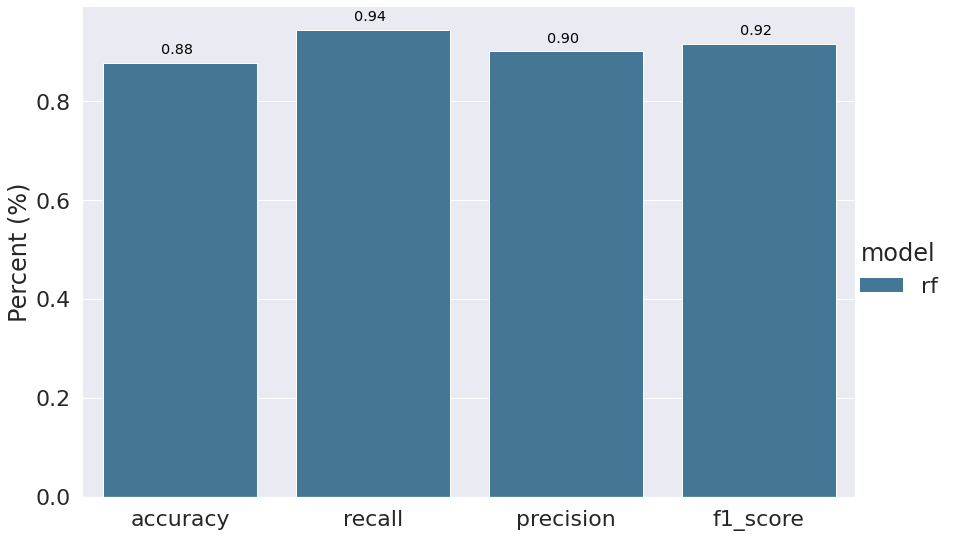

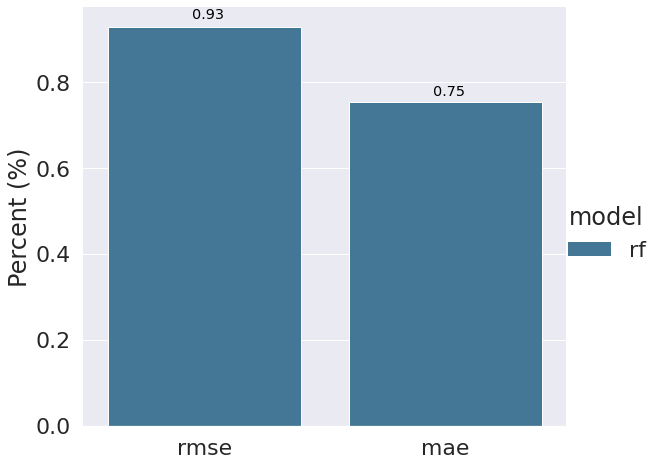

In [ ]:
eval = evaluator()
features =  pd.read_pickle('/content/drive/My Drive/clothes_attr.pkl')
df = pd.DataFrame(columns=['user','metric','score'])
df2 = pd.DataFrame(columns=['user','metric','score'])
for u in range(1):
  #model = cb_rf(0,features)
  grade_df = rf.evaluate_system(all_train,all_test)
  a,b = eval.average_arpf_rm(data=grade_df,cols=columns,threshold=2.5,model='rf')
  df = df.append(a)
  df2 = df2.append(b)

eval.visualize_bars(df = df,axe_x='metric',axe_y='score',hue='model',title='model',x_dist=0.3,hei_=8,asp_=9/6)

eval.visualize_bars(df = df2,axe_x='metric',axe_y='score',hue='model',title='model',x_dist=0.35,hei_=7,asp_=8/7)

In [ ]:
dataset

userId  movieId  rating
0            1        1     4.0
1            1        3     4.0
2            1        6     4.0
3            1       47     5.0
4            1       50     5.0
...        ...      ...     ...
100831     610   166534     4.0
100832     610   168248     5.0
100833     610   168250     5.0
100834     610   168252     5.0
100835     610   170875     3.0

[100836 rows x 3 columns]

# **`cb_rf_cov_nov.py`**

Streaming output truncated to the last 5000 lines.
[I 2021-02-26 15:54:42,297] Trial 4 finished with value: 0.9023561703060268 and parameters: {'n_estimators': 38, 'max_depth': 28.292235352542686}. Best is trial 3 with value: 0.8753692345429165.
[I 2021-02-26 15:54:42,354] Trial 5 finished with value: 0.859576869227161 and parameters: {'n_estimators': 38, 'max_depth': 30.781697816633958}. Best is trial 5 with value: 0.859576869227161.
[I 2021-02-26 15:54:42,402] Trial 6 finished with value: 0.8989533808216865 and parameters: {'n_estimators': 31, 'max_depth': 18.13123032186127}. Best is trial 5 with value: 0.859576869227161.
[I 2021-02-26 15:54:42,452] Trial 7 finished with value: 0.8814625311863807 and parameters: {'n_estimators': 33, 'max_depth': 31.597449888024652}. Best is trial 5 with value: 0.859576869227161.
[I 2021-02-26 15:54:42,508] Trial 8 finished with value: 0.8682704155769976 and parameters: {'n_estimators': 36, 'max_depth': 22.96286474502876}. Best is trial 5 with value: 

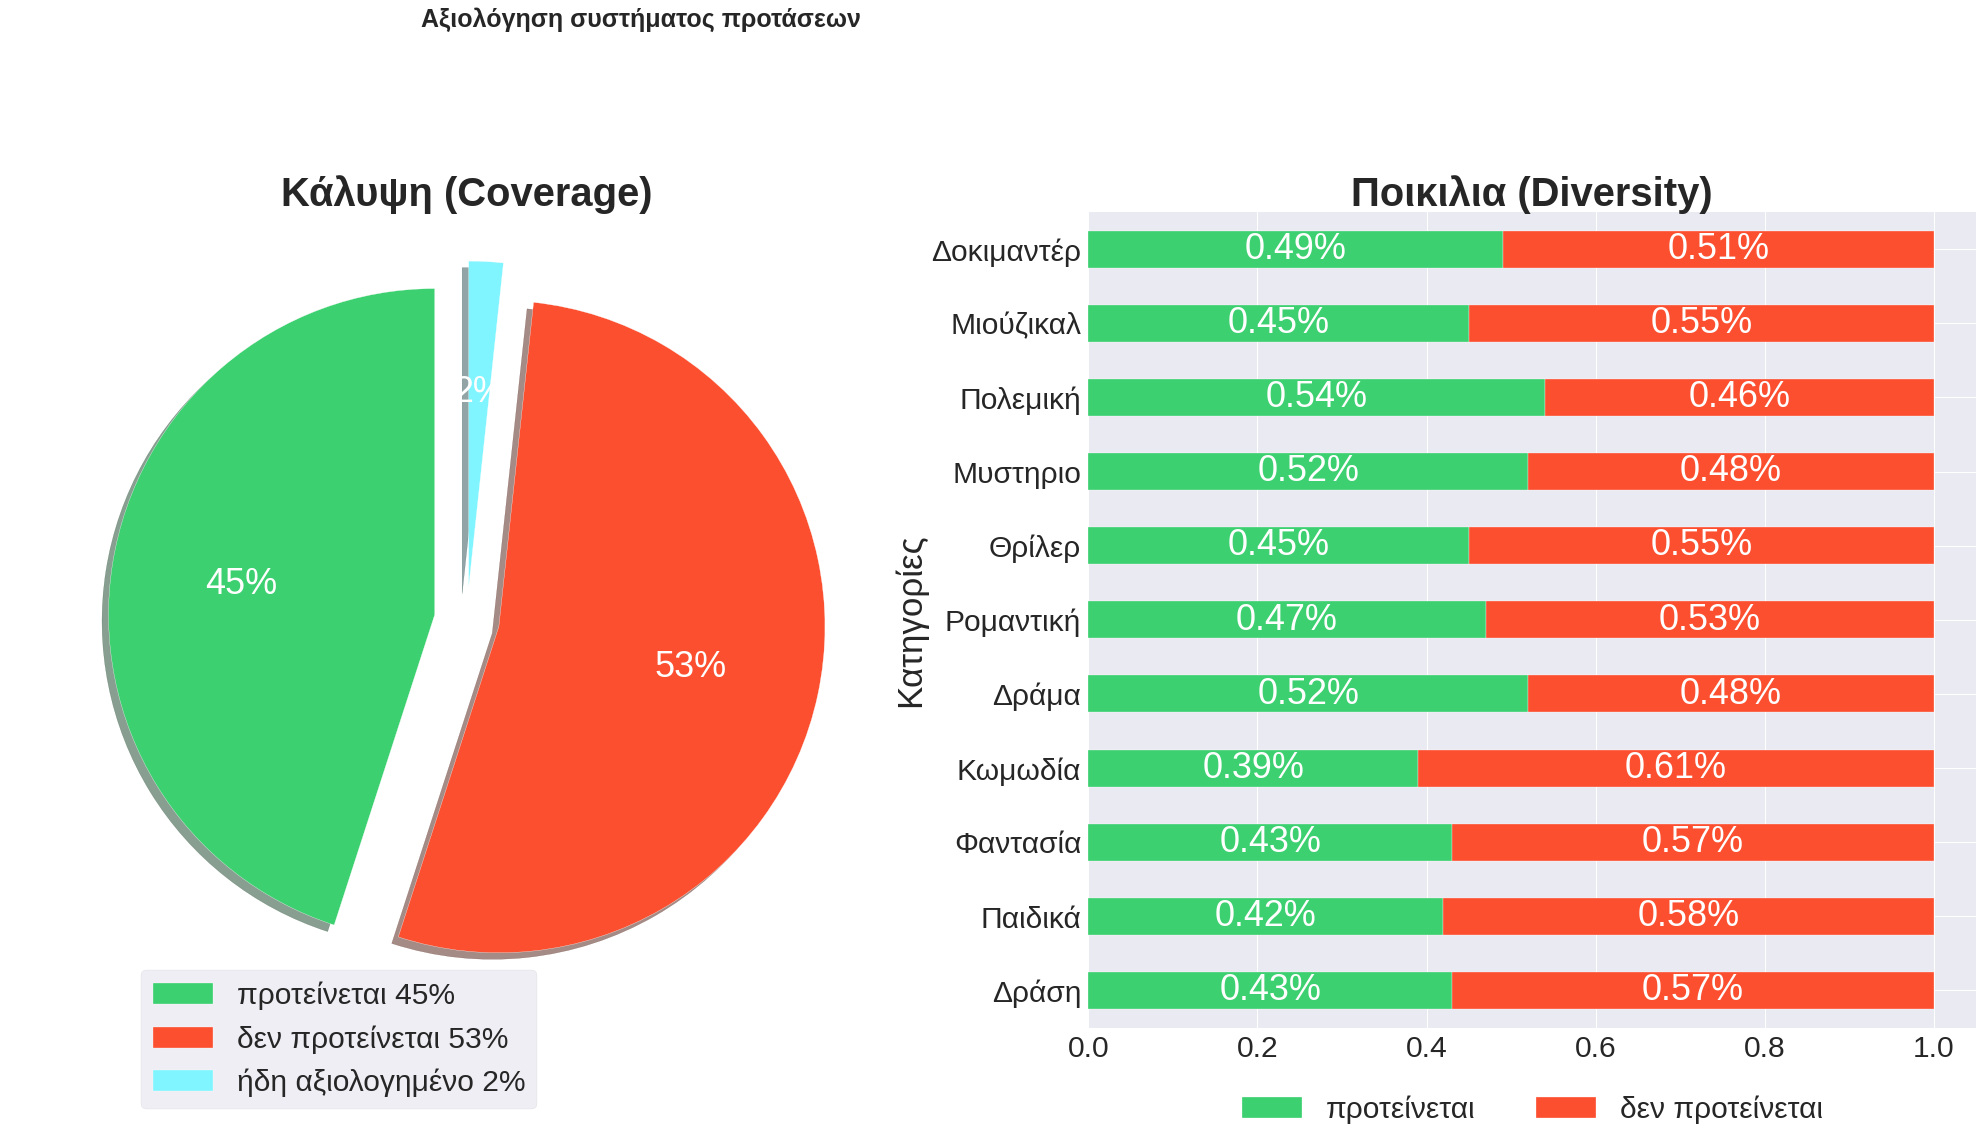

In [ ]:
cat_ = features_df
translator = pd.DataFrame(columns=['category'])
translator['category'] = features_df['category'].unique().tolist()
translator['gr'] = features_df['category'].unique().tolist()
translator = translator.set_index(keys='gr')
dffff = rf.coverage(threshold=3.74)
df2 = rf.novelty(cat_,3.74,translator)
 
evaluator().visualize_pie(dffff,df2)

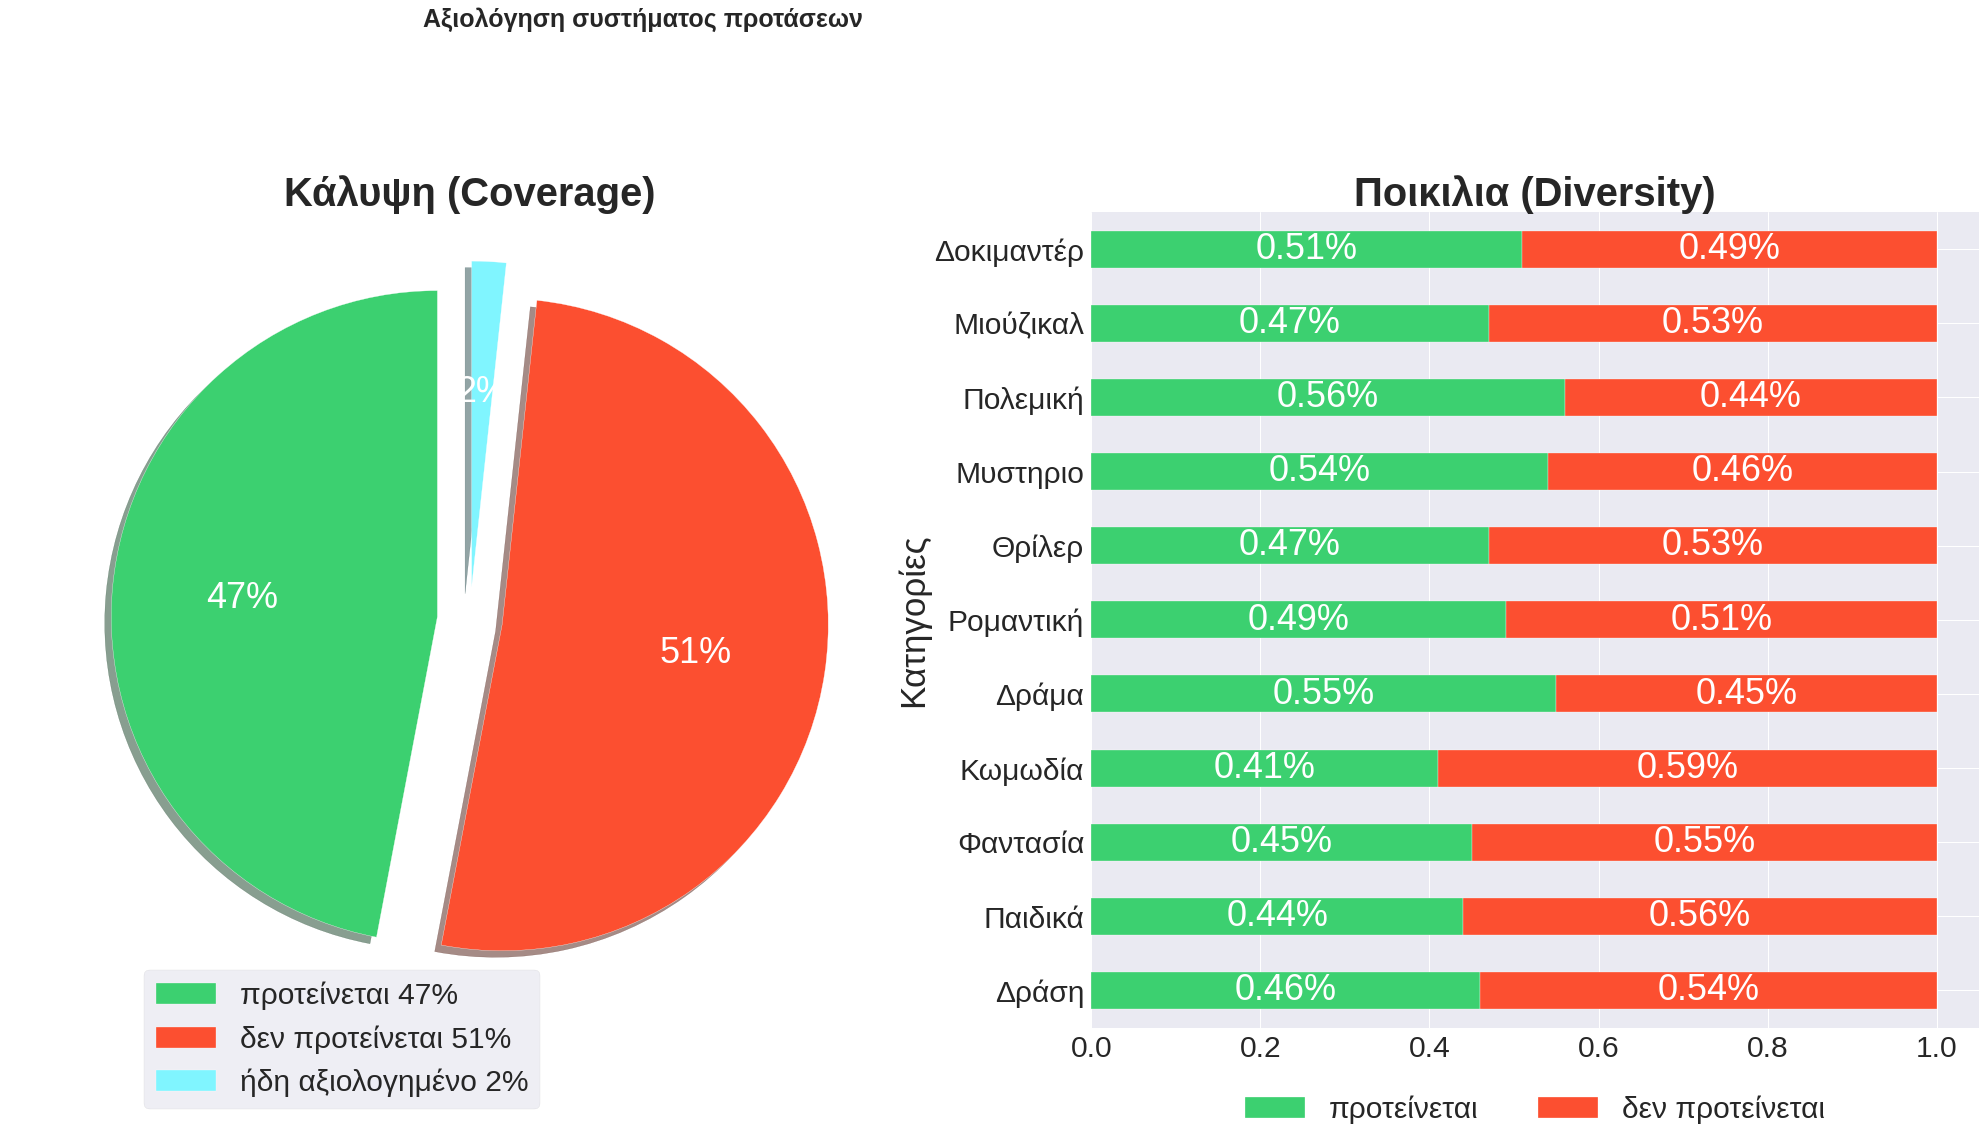

In [ ]:
cat_ = features_df
translator = pd.DataFrame(columns=['category'])
translator['category'] = features_df['category'].unique().tolist()
translator['gr'] = features_df['category'].unique().tolist()
translator = translator.set_index(keys='gr')
dffff = rf.coverage(threshold=3.7)
df2 = rf.novelty(cat_,3.7,translator)
 
evaluator().visualize_pie(dffff,df2)

# **`cb_nn.py`**

In [ ]:
from keras.models import Sequential
from keras.layers import Dense,Dropout
import tensorflow as tf
from sklearn import preprocessing

class cb_nn():
  def __init__(self,input_user,features):
    self.features = features
    self.recdf = -1
    self.dataset = dataset
    self.evdf = -1
    self.columns = columns

    self.input_user = input_user



  def make_recommendation(self):

    if type(self.recdf) == type(pd.DataFrame()):
      return self.recdf
    
    # make local variables
    dataset = self.dataset
    columns = self.columns
    features = self.features

    # get unrated ratings per user
    all_users = dataset[columns[0]].unique()
    all_items = set(dataset[columns[1]].unique())

    # dataframe for recommendation
    df = pd.DataFrame(columns=[columns[0],columns[1],'y_rec'])
    for i in all_users:
      u_data = dataset.loc[dataset[columns[0]] == i]
      train_X = features.loc[u_data[columns[1]].tolist()]
   
      train_y = u_data[columns[2]].tolist()
 
      model = self.model_init()
      earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='min',restore_best_weights=True)
      reduce_lr_loss = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, min_delta=1e-4, mode='min')
 
      history = model.fit(np.array(train_X.values), np.array(train_y), epochs=10,callbacks=[earlyStopping,reduce_lr_loss], validation_split=0.1)


      rated = set(u_data[columns[1]].unique())
      unrated = list(all_items - rated)
      if len(unrated)>0:
        test_X = features.loc[unrated]
        y_rec = model.predict(test_X)
        p_data = pd.DataFrame(columns=[columns[0],columns[1],'y_rec'])
        p_data[columns[0]] = [int(i) for k in range(len(unrated))]
        p_data[columns[1]] = unrated
        p_data['y_rec'] = y_rec
        df = df.append(pd.DataFrame(data=p_data.values,columns=[columns[0],columns[1],'y_rec']))

    df = df.reset_index().drop(columns='index')
 
    self.recdf = df

    return df  

  def evaluate_system(self,all_train,all_test):
    if type( self.evdf) == type(pd.DataFrame()):
      return  self.evdf
    # make local variables
    dataset = self.dataset
    columns = self.columns
    features = self.features

    all_users = dataset[columns[0]].unique()

    df = pd.DataFrame(columns=[columns[0],columns[1],'y_true','y_pred'])

    for i in all_users:

      u_train = all_train.loc[all_train[columns[0]] == i]
      u_test = all_test.loc[all_test[columns[0]] == i]

      f_train = features.loc[u_train[columns[1]].tolist()]
      f_test = features.loc[u_test[columns[1]].tolist()]

      train_y = u_train[columns[2]].tolist()
      test_y = u_test[columns[2]].tolist()
   
      model = self.model_init()
      earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, verbose=0, mode='min',restore_best_weights=True)
      reduce_lr_loss = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=15, verbose=1, min_delta=1e-4, mode='min')
    
  
   
      history = model.fit(np.array(f_train.values), np.array(train_y), epochs=25,callbacks=[earlyStopping,reduce_lr_loss], validation_split=0.2)

      y_pred = model.predict(f_test.values)

  
      u_df = pd.DataFrame(columns=[columns[0],columns[1],'y_true','y_pred'])
      u_df[columns[0]] = u_test[columns[0]].tolist()
      u_df[columns[1]] = u_test[columns[1]].tolist()
      u_df['y_true'] = u_test[columns[2]].tolist()
      u_df['y_pred'] = y_pred

      df = df.append(u_df)
    
    df = df.reset_index().drop(columns='index')
    self.evdf = df
    return df




  def recommend(self,itemsTopredict):
    # init regressor rf
    model = self.model_init()
    # train 
    # train 
    earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7, verbose=0, mode='min',restore_best_weights=True)
    reduce_lr_loss = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, min_delta=1e-4, mode='min')
 
    history = model.fit(np.array(self.rated_clothes.values), np.array(self.ratings), epochs=15,callbacks=[earlyStopping,reduce_lr_loss], validation_split=0.1)

    # predict
    pred_X = self.unrated_clothes.loc[itemsTopredict]
    y_pred = model.predict(pred_X)
    # result dataframe
    df = pd.DataFrame()
    df['clothId'] = pred_X.index.tolist()
    df['nn_pred'] = y_pred
   
    return df

  def split_and_predict(self):
    # init regressor rf
    model = self.model_init()
    # split data
    train_X, test_X, train_y, test_y = train_test_split(self.rated_clothes, self.ratings, test_size=0.2, random_state=1)
    # train 
    earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='min',restore_best_weights=True)
    reduce_lr_loss = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, min_delta=1e-4, mode='min')

    history = model.fit(np.array(train_X.values), np.array(train_y), epochs=10,callbacks=[earlyStopping,reduce_lr_loss], validation_split=0.1)
    # predict
    y_pred = model.predict(test_X)
    
    # result dataframe
    df = pd.DataFrame(columns=['clothId','y_pred','y_true'])
    df['clothId'] = test_X.index.tolist()
    df['y_true'] = test_y
    df['y_pred'] = y_pred

    return df
     
  def model_init(self):
    # make local
    dataset = self.dataset
    columns = self.columns

    model = Sequential()
    model.add(Dense(2048, input_shape=(self.features.shape[1], ), activation='relu', name='dense_1'))
    model.add(Dropout(0.2))
    #model.add(tf.keras.layers.BatchNormalization())
    model.add(Dense(1024, activation='relu', name='dense_2'))
    model.add(Dropout(0.1))
    model.add(Dense(512, activation='relu', name='dense_3'))
    model.add(Dropout(0.1))
    model.add(Dense(256, activation='relu', name='dense_4'))
    model.add(Dense(1, activation='sigmoid', name='dense_output'))
    min_rating = min(dataset[columns[2]].tolist())
    max_rating = max(dataset[columns[2]].tolist())
    model.add(Lambda(lambda x:   (max_rating-min_rating)*x + min_rating ))
    model.compile(optimizer='adam', loss='mse', metrics=['mse'])

    return model

  def convert_index(self,old):
    id_db = pd.read_pickle('/content/drive/My Drive/id_db.pkl')
    new_list = id_db['id'].tolist()
    old_list = id_db['db_id'].tolist()
    new = []
    for j in range(len(old)):
      for i in range(len(id_db)):
        if old[j] in old_list[i]:
          new.append(new_list[i])
    return new
    
  def hyb_eval(self,train,test):
    # init regressor rf
    model = self.model_init()
    d_train = self.rated_clothes.copy()
    d_train['rating'] = self.ratings.copy()
    train_X = d_train.loc[train['clothId'].tolist()]
  
    train_y = train_X['rating'].tolist()
  
    train_X = train_X.drop(columns='rating')
    d_test = self.rated_clothes.copy()
    d_test['rating'] = self.ratings
    test_X = d_test.loc[test['clothId'].tolist()]
   
    test_y = test_X['rating'].tolist()
    
    test_X = test_X.drop(columns='rating')
    # train 
    earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='min',restore_best_weights=True)
    reduce_lr_loss = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, min_delta=1e-4, mode='min')

    history = model.fit(np.array(train_X.values), np.array(train_y), epochs=10,callbacks=[earlyStopping,reduce_lr_loss], validation_split=0.05)
    # predict
    y_pred = model.predict(test_X)
    
    # result dataframe
    df = pd.DataFrame(columns=['clothId','nn_pred'])
    df['clothId'] = test_X.index.tolist()
    #df['y_true'] = test_y
    df['nn_pred'] = y_pred

    return df

 

  def coverage(self,threshold):

    if type(self.recdf) != type(pd.DataFrame()):
      pred_ratings = self.make_recommendation()
    else:
      pred_ratings = self.recdf

    already_rated = len(self.dataset)
    
    high_rated = len(pred_ratings.loc[pred_ratings['y_rec']>threshold])
    
    low_rated = len(pred_ratings.loc[pred_ratings['y_rec']<=threshold])

    unrated = len(pred_ratings.loc[pred_ratings['y_rec']==np.nan])
    
    cov_df = pd.DataFrame()

    cov_df['recommended'] = [high_rated]

    cov_df['not recommended'] = [low_rated]

    cov_df['cannot recommended'] = [unrated]

    cov_df['already rated'] = [already_rated]
    
    return cov_df
    
  
    
  def novelty(self,cat_,threshold,translator_=False):

    if type(self.recdf) != type(pd.DataFrame()):
      pred_ratings = self.make_recommendation()
    else:
      pred_ratings = self.recdf

    pred_ratings = pred_ratings.merge(cat_,on=columns[1],how='inner')

    categories = pred_ratings['category'].unique()

    c_ratings = []
    for i in range(len(categories)):
      ratings = []
      fr = pred_ratings.loc[pred_ratings['category'] == categories[i]]
      ratings.append(round(len(fr.loc[fr['y_rec'] >=threshold])  / len(fr.loc[fr['y_rec'] >=0]),2) )
      ratings.append(round(len(fr.loc[fr['y_rec'] <threshold])  / len(fr.loc[fr['y_rec'] >=0]) ,2))
      c_ratings.append(ratings)

    df = pd.DataFrame(data=c_ratings , columns=['προτείνεται','δεν προτείνεται'])
    if type(translator_) == bool:
      return df

    categories_gr = []

    for i in range(len(categories)):
      categories_gr.append(translator_.loc[translator_['category'] == categories[i]].index.tolist()[0])
    df['κατηγορίες'] = categories_gr

    df = df.set_index(keys='κατηγορίες')

    return df

# **`cb_nn_system.py`**

In [ ]:

nn = cb_nn(0,features)

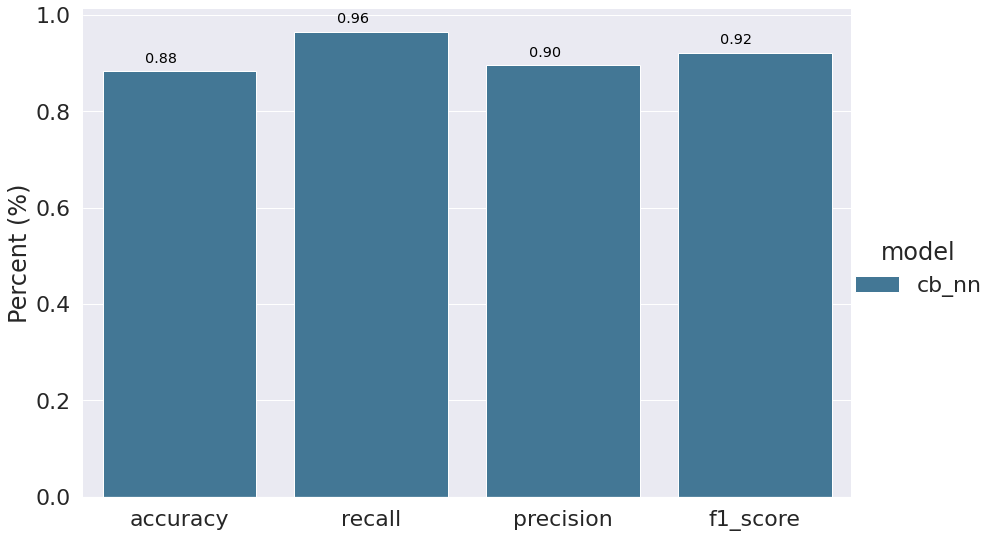

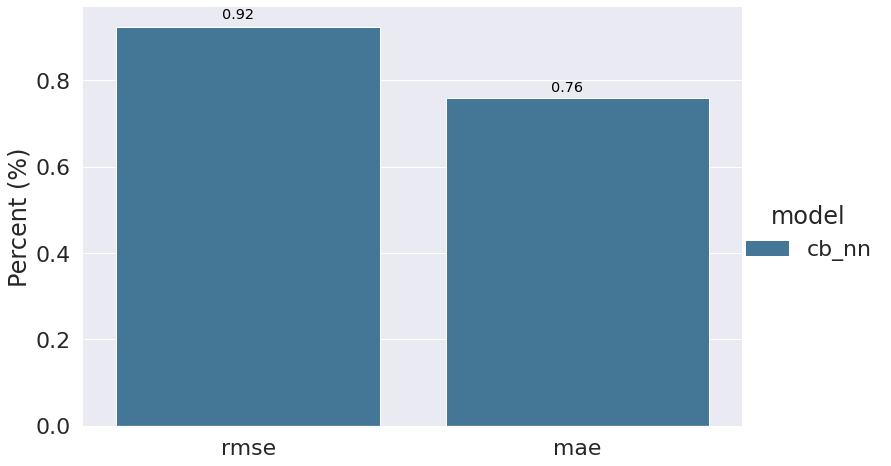

In [ ]:
features =  pd.read_pickle('/content/drive/My Drive/clothes_attr.pkl')
eval = evaluator()

df = pd.DataFrame(columns=['user','metric','score'])
df2 = pd.DataFrame(columns=['user','metric','score'])

for u in range(1):
  #model = cb_nn(0,features)
  grade_df = nn.evaluate_system(all_train,all_test)
  a,b = eval.average_arpf_rm(data=grade_df,cols=columns,threshold=2.5,model='cb_nn')
  df = df.append(a)
  df2 = df2.append(b)
eval.visualize_bars(df = df,axe_x='metric',axe_y='score',hue='model',title='model',x_dist=0.22,hei_=8,asp_=9/6)
eval.visualize_bars(df = df2,axe_x='metric',axe_y='score',hue='model',title='model',x_dist=0.32,hei_=7,asp_=9/6)


# **`cb_nn_cov_nov.py`**

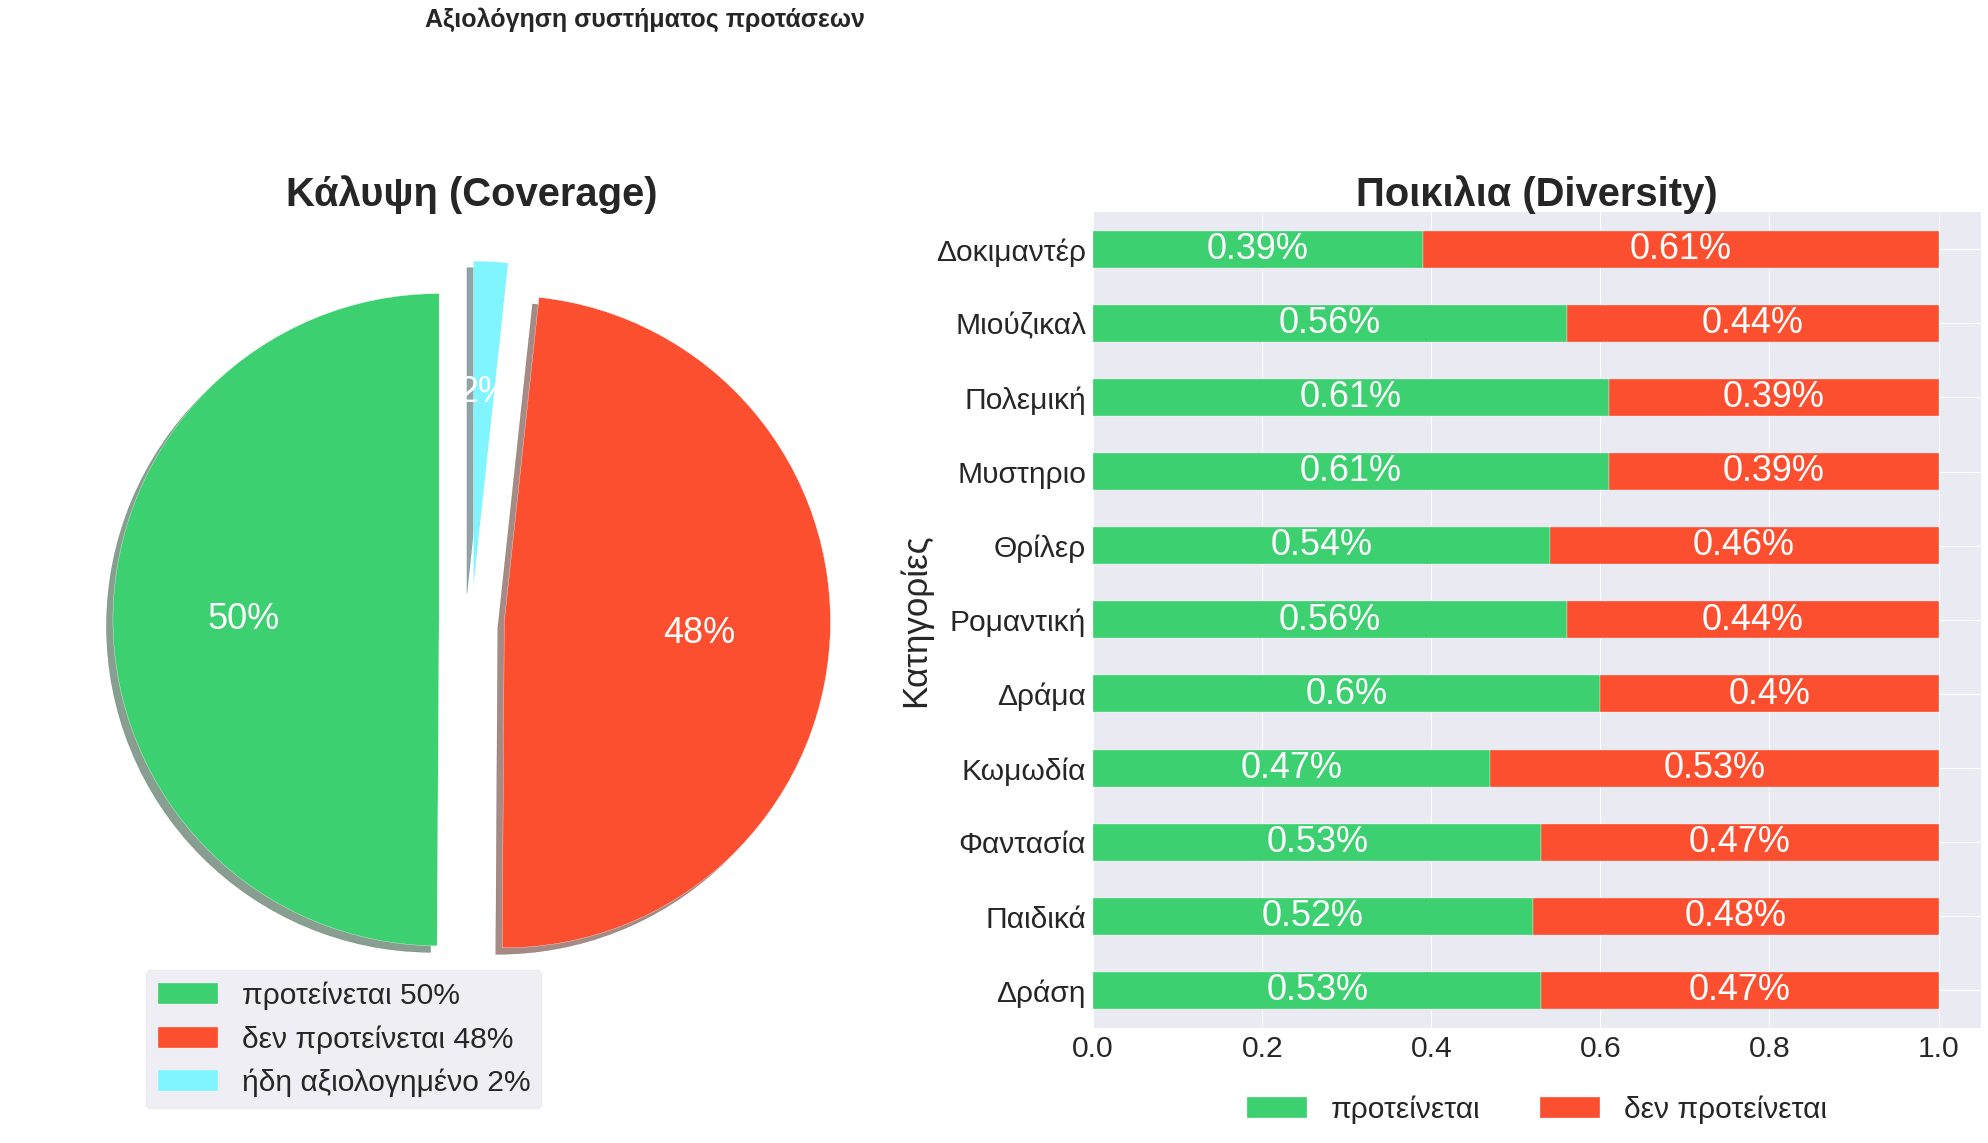

In [ ]:
 
cat_ = features_df
translator = pd.DataFrame(columns=['category'])
translator['category'] = features_df['category'].unique().tolist()
translator['gr'] = features_df['category'].unique().tolist()
translator = translator.set_index(keys='gr')
dffff = nn.coverage(threshold=3.6)
df2 = nn.novelty(cat_,3.6,translator)
 
evaluator().visualize_pie(dffff,df2)